### Classification Task: predict bad flag (assuming bad = overdue)

In [472]:
# load all necessary libraries
import warnings
warnings.filterwarnings('ignore')
from typing import List, Tuple, Optional

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from statsmodels.stats import proportion
from itertools import combinations, product
import datetime
from tqdm.notebook import tqdm
import category_encoders as ce
import shap
from pprint import pprint

import missingno as msg

from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, cross_val_score, GridSearchCV, KFold
from sklearn.pipeline import make_pipeline, make_union
from sklearn.compose import make_column_transformer
from sklearn.base import BaseEstimator, ClassifierMixin, TransformerMixin
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, PowerTransformer, PolynomialFeatures
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import SimpleImputer, IterativeImputer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier, IsolationForest
from sklearn.metrics import confusion_matrix, f1_score, classification_report, auc, precision_recall_curve, confusion_matrix
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, recall_score, accuracy_score
from sklearn.manifold import TSNE
from sklearn.feature_selection import SelectFromModel

from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.pipeline import make_pipeline as make_pipe

import optuna
from optuna.samplers import TPESampler

import catboost
from catboost import CatBoostClassifier, Pool, EFeaturesSelectionAlgorithm, EShapCalcType

In [2]:
seed = 42  # seed for reproducability
np.random.seed(seed)
TARGET = 'bad_flag'  # name of target column in dataset
path = r'revo_ds_test_task.csv'  # dataset path
np.set_printoptions(2)  # allow printing human readable numbers
plt.style.use('ggplot')  # set style for all plots
pd.set_option('display.max_columns', None)  # display all collumns

In [3]:
df = pd.read_csv('revo_ds_test_task.csv')
df.set_index('loanKey', inplace=True)  # set index of dataframe to preserve information about unique loan and discard from data
df.sample(5, random_state=seed)  # display 5 random rows

rep_loan_date  first_loan  dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  \
loanKey                                                                
798820     2016-11-07  2015-09-07        NaN         NaN         NaN   
612648     2016-08-18  2016-02-08        NaN         NaN         NaN   
452498     2016-04-20  2016-03-12        NaN         NaN         NaN   
580963     2016-07-22  2015-08-14        NaN         NaN         NaN   
518998     2016-06-01  2015-09-29        NaN         NaN         NaN   

        first_overdue_date  close_loans_cnt federal_district_nm  TraderKey  \
loanKey                                                                      
798820                 NaN              7.0            region_3          6   
612648                 NaN              1.0            region_6         12   
452498                 NaN              0.0            region_2         12   
580963                 NaN              1.0            region_6         26   
518998                 NaN              1.0            region_3          6   

         payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
loanKey                                                                   
798820                0               0              16               0   
612648                0               4               0               2   
452498                0               0               0               2   
580963                0               0               5               6   
518998                0               0               8               0   

         payment_type_4  payment_type_5  past_billings_cnt     score_1  \
loanKey                                                                  
798820                0               0               14.0  550.235369   
612648                0               0                6.0         NaN   
452498                1               0                1.0  561.999471   
580963                0               0               10.0  590.376406   
518998                0               0                8.0  593.493342   

            score_2   age  gender  bad_flag  
loanKey                                      
798820          NaN  43.0   False         0  
612648   576.875277  26.0   False         0  
452498          NaN  28.0    True         1  
580963          NaN  30.0   False         0  
518998          NaN  47.0   False         0

### EDA (first step)

In [4]:
# check for duplicates in rows
print(f'Number of duplicates in rows: {df.duplicated().sum()}')

# check for constant features (redundant, that has not predictive power)
# count categorical features cardinality: to decide encoding strategy further
for column in df.columns:
    uniq = df[column].nunique()
    if uniq < 2:
        print(f'{column} is constant')
        df.drop([column], axis=1, inplace=True)  # drop this column as non-informative
    elif df[column].dtype == np.object:
        print(f'{column} has {uniq} values')

Number of duplicates in rows: 0
rep_loan_date has 582 values
first_loan has 634 values
first_overdue_date has 78 values
federal_district_nm has 8 values
payment_type_5 is constant


In [5]:
df.describe()
# score_1, score_2, age are close to normal distribution (mean ~ median)
# maybe some outliers in payment_types, dpd_N_cnt but there is no confidence whether they are significant

dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  close_loans_cnt    TraderKey  \
count  675.000000  675.000000  675.000000      4142.000000  4157.000000   
mean     1.444444    0.733333    0.280000         1.184693    12.338225   
std      0.900599    0.764572    0.502339         1.723715     9.902927   
min      0.000000    0.000000    0.000000         0.000000     1.000000   
25%      1.000000    0.000000    0.000000         0.000000     6.000000   
50%      1.000000    1.000000    0.000000         1.000000     6.000000   
75%      2.000000    1.000000    1.000000         2.000000    14.000000   
max      7.000000    5.000000    3.000000        31.000000    80.000000   

       payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
count     4157.000000     4157.000000     4157.000000     4157.000000   
mean         0.018523        0.596103        3.755834        0.758239   
std          0.330359        2.564887        3.810703        2.212487   
min          0.000000        0.000000        0.000000        0.000000   
25%          0.000000        0.000000        1.000000        0.000000   
50%          0.000000        0.000000        3.000000        0.000000   
75%          0.000000        0.000000        6.000000        0.000000   
max         15.000000       81.000000       33.000000       35.000000   

       payment_type_4  past_billings_cnt      score_1     score_2  \
count     4157.000000        3909.000000  3507.000000  239.000000   
mean         0.019485           4.979023   578.911345  552.546610   
std          0.245960           3.491556    48.989869   21.492840   
min          0.000000           1.000000   384.220628  485.874267   
25%          0.000000           2.000000   547.429791  535.545724   
50%          0.000000           4.000000   588.531315  556.757944   
75%          0.000000           6.000000   612.323090  567.608057   
max          7.000000          21.000000   691.528420  603.311653   

               age     bad_flag  
count  4157.000000  4157.000000  
mean     34.561222     0.100313  
std      10.834143     0.300453  
min      18.000000     0.000000  
25%      26.000000     0.000000  
50%      32.000000     0.000000  
75%      41.000000     0.000000  
max      74.000000     1.000000

In [6]:
df.describe(include=np.object)  # inspecting categorical features

rep_loan_date  first_loan first_overdue_date federal_district_nm
count           4157        4157                675                4146
unique           582         634                 78                   8
top       2016-10-15  2015-11-13         2016-01-15            region_3
freq              31          22                 63                1595

In [7]:
# converting date features to date_time
df['rep_loan_date'] = pd.to_datetime(df['rep_loan_date'])
df['first_loan'] = pd.to_datetime(df['first_loan'])
df['first_overdue_date'].fillna(0, inplace=True)  # fill no-overdue values with 0: first date 1970-01-01
df['first_overdue_date'] = pd.to_datetime(df['first_overdue_date'])

In [8]:
df.info()
# inspect data dtypes, number of missing values
# hard to say why score_1 and score_2 are different columns. To get total score better to concatenate them and fill with 0

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4157 entries, 708382 to 521420
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   rep_loan_date        4157 non-null   datetime64[ns]
 1   first_loan           4157 non-null   datetime64[ns]
 2   dpd_5_cnt            675 non-null    float64       
 3   dpd_15_cnt           675 non-null    float64       
 4   dpd_30_cnt           675 non-null    float64       
 5   first_overdue_date   4157 non-null   datetime64[ns]
 6   close_loans_cnt      4142 non-null   float64       
 7   federal_district_nm  4146 non-null   object        
 8   TraderKey            4157 non-null   int64         
 9   payment_type_0       4157 non-null   int64         
 10  payment_type_1       4157 non-null   int64         
 11  payment_type_2       4157 non-null   int64         
 12  payment_type_3       4157 non-null   int64         
 13  payment_type_4       4157 

In [8]:
df['gender'] = df['gender'].map({True: 1, False: 0})

In [9]:
df.gender.value_counts()

0    3570
1     587
Name: gender, dtype: int64

In [10]:
numerical_columns = df.drop(TARGET, axis=1).select_dtypes(include='number').columns.tolist()
categorical_columns = df.drop(TARGET, axis=1).select_dtypes(include='object').columns.tolist()

### Class imbalance

**Imbalance in target distribution**

In case of class imbalance first decide wich metric to use for model evaluation:

* f-score: $\frac{(1 + \beta)\cdot precision \cdot recall}{\beta^2 \cdot precision + recall}$;
* precision, recall;
* roc_auc: $\frac{TPR}{FPR}$ - shows model ability to devide negative sample from positive (probability of correctly identify random sample as positive when it is positive and negative when it is negative), BUT roc_auc acts with no respect to class imbalance!

Secondly decide how to handle such imbalance (for model ability to detect positive (minority) samples):

* oversampling: randomly copy and paste in dataset minority samples to increase pos/neg ratio - often leads to model overfitting as model faces the same samples;
* undersampling: randomly drop majority samples from dataset - leads to (meaningful) information lost;
* generate new synthetic samples: SMOTE and its derivatives (recommended to follow by random under sampling) - generate similar (close in terms of distance) to minority class samples. SMOTETomek (SMOTEENN) - combination of new sample generating and eliminating majority sample, that are close to the decision border - it is necessary to be accurate when defining sampling strategy, as it often also leads to overfit the model;
* Class weights. Use corresponding weights for loss function penalty. Penalize model stronger when minority class classified incorrectly. For example in sklearn: *compute_class_weigt* or class_weight parameter in model init method, in catboost: $CW_k = \frac{max^K_{c=1}(\sum_{t_i=c} w_i)}{\sum_{t_i=k} w_i}$ or more soft $CW_k = \sqrt\frac{max^K_{c=1}(\sum_{t_i=c} w_i)}{\sum_{t_i=k} w_i}$

Note: resample only train samples unless test predictions would be too optimistic while model would fail on new completely data!

Note: for regresion task always check target distribution. Often transforming target variable to normal distribution (log, sqrt, PowerTransformer, etc.) improves model performance!

In [11]:
# inspect target variable distribution
df[TARGET].value_counts(normalize=True)

0    0.899687
1    0.100313
Name: bad_flag, dtype: float64

### Define some useful functions

In [12]:
def reduce_memory_df(df):
    """Reduce memory usage by converting data to more appropriate dtypes"""
    start_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    end_mem = df.memory_usage().sum() / 1024 ** 2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    return df

# report
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    """display classification report"""
    print('Train\n', classification_report(y_train, y_train_pred, digits=4))
    print('Test\n', classification_report(y_test, y_test_pred, digits=4))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')
        print(f'Train GINI: {(2 * roc_train - 1):.3f}, Test GINI: {(2 * roc_test - 1):.3f}')

# confusion matrix
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.grid(None)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=4)
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    # print(cm)

    thresh = cm.max() / 2.
    for i, j in product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_roc_curve(fpr, tpr, model_name="", color=None):
    plt.plot(fpr, tpr, label='%s: ROC curve (area = %0.2f)' %
             (model_name, auc(fpr, tpr)), color=color)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('%s: Receiver operating characteristic curve' % model_name)
    plt.legend(loc="lower right")
    
def plot_precision_recall_curve(recall, precision, model_name="", color=None):
    plt.plot(recall, precision, label='%s: Precision-Recall curve (area = %0.2f)' %
             (model_name, auc(recall, precision)), color=color)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title("%s: Precision-Recall curve" % model_name)
    plt.axis([0.0, 1.0, 0.0, 1.05])
    plt.legend(loc="lower left")

# calibration probs
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix]

def show_proba_calibration_plots(y_predicted_probs, y_true_labels):
    """display probability calibration results"""
    preds_with_true_labels = np.array(list(zip(y_predicted_probs, y_true_labels)))

    thresholds = []
    precisions = []
    recalls = []
    f1_scores = []

    for threshold in np.linspace(0.1, 0.9, 18):
        thresholds.append(threshold)
        precisions.append(precision_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        recalls.append(recall_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))
        f1_scores.append(f1_score(y_true_labels, list(map(int, y_predicted_probs > threshold))))

    scores_table = pd.DataFrame({'f1':f1_scores,
                                 'precision':precisions,
                                 'recall':recalls,
                                 'probability':thresholds}).sort_values('f1', ascending=False).round(3)
  
    figure = plt.figure(figsize = (15, 5))

    plt1 = figure.add_subplot(121)
    plt1.plot(thresholds, precisions, label='Precision', linewidth=4)
    plt1.plot(thresholds, recalls, label='Recall', linewidth=4)
    plt1.plot(thresholds, f1_scores, label='F1', linewidth=4)
    plt1.set_ylabel('Scores')
    plt1.set_xlabel('Probability threshold')
    plt1.set_title('Probabilities threshold calibration')
    plt1.legend(bbox_to_anchor=(0.25, 0.25))   
    plt1.table(cellText = scores_table.values,
               colLabels = scores_table.columns, 
               colLoc = 'center', cellLoc = 'center', loc = 'bottom', bbox = [0, -1.3, 1, 1])

    plt2 = figure.add_subplot(122)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 0][:, 0], 
              label='Another class', color='royalblue', alpha=1)
    plt2.hist(preds_with_true_labels[preds_with_true_labels[:, 1] == 1][:, 0], 
              label='Main class', color='darkcyan', alpha=0.8)
    plt2.set_ylabel('Number of examples')
    plt2.set_xlabel('Probabilities')
    plt2.set_title('Probability histogram')
    plt2.legend(bbox_to_anchor=(1, 1))

    plt.show()
    
def cross_validation(clf, X, y, scoring='f1', cv=5):
    """cross validation"""
    scores = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring=scoring, n_jobs=-1)
    print(f'Меры правильности перекрекстной оценки: {scores}')
    print(f'Точность перекретсной оценки: {np.mean(scores):.3f} +/- {np.std(scores):.3f}')
    return scores

def categorical_stats(df=df, target=TARGET, alpha=0.05, sample_size=500):
    """chi2 stat test for categorical features"""
    data = df.copy().sample(sample_size)
    columns_to_analize = data.select_dtypes(include=['category', 'object']).columns
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[target])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature {factor} has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)
        
def statistic_output(*columns, df=df, target=TARGET, alpha=0.05, sample_size=0):
    """statistical test for numerical features"""
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    for column in columns:
        df_sampled = data[[column, target]].sample(sample_size, random_state=1)
        factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
        factor_b = df_sampled.loc[df_sampled[target] == 1][column]
        var_a, var_b = factor_a.var(), factor_b.var()   
        _, pvalue = stats.shapiro(df_sampled[column])
        if pvalue >= alpha:
            _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
        else:
            if len(factor_a) == 0 or len(factor_b) == 0:
                continue
            _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
        if pvalue < alpha:
            print(f'Factor "{column}" has statistical impact on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}).')
        else:
            print(f'Factor "{column}" does not affect target.')
            
def categorical_output(*columns, df=df, target=TARGET, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    data['id'] = np.arange(len(data)).astype('object')
    if sample_size <= 0:
        sample_size = int(0.05 * len(data))
    for column in columns:
        print(column)
        categories = data[column].unique().tolist()
        for pair in combinations(categories, r=2):
            a, b = pair
            if a != b:
                data_ = data.loc[data[column].isin(pair), ['id', column, target]].sample(sample_size, random_state=seed)
                table = data_.pivot_table(values='id', index=column, columns=target, aggfunc='count').fillna(0)
                try:
                    _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                except ValueError:
                    continue
                if pvalue >= alpha:
                    print(f'Categories {a} and {b} can be united. P-value: {pvalue:.4f}')
                else:
                    print(f'Categories {a} and {b} have different frequencies with target, p-value: {pvalue:.4f}.')

In [204]:
def create_bootstrap_samples(data: np.array, n_samples: int = 1000) -> np.array:
    """
    Создание бутстреп-выборок.

    Parameters
    ----------
    data: np.array
        Исходная выборка, которая будет использоваться для
        создания бутстреп выборок.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_idx: np.array
        Матрица индексов, для создания бутстреп выборок.

    """
    bootstrap_idx = np.random.randint(
        low=0, high=len(data), size=(n_samples, len(data))
    )
    return bootstrap_idx


def create_bootstrap_metrics(y_true: np.array,
                             y_pred: np.array,
                             metric: callable,
                             n_samlpes: int = 1000) -> List[float]:
    """
    Вычисление бутстреп оценок.

    Parameters
    ----------
    y_true: np.array
        Вектор целевой переменной.

    y_pred: np.array
        Вектор прогнозов.

    metric: callable
        Функция для вычисления метрики.
        Функция должна принимать 2 аргумента: y_true, y_pred.

    n_samples: int, optional, default = 1000
        Количество создаваемых бутстреп выборок.
        Опциональный параметр, по умолчанию, равен 1000.

    Returns
    -------
    bootstrap_metrics: List[float]
        Список со значениями метрики качества на каждой бустреп выборке.

    """
    scores = []

    if isinstance(y_true, pd.Series):
        y_true = y_true.values

    bootstrap_idx = create_bootstrap_samples(y_true)
    for idx in bootstrap_idx:
        y_true_bootstrap = y_true[idx]
        y_pred_bootstrap = y_pred[idx]

        score = metric(y_true_bootstrap, y_pred_bootstrap)
        scores.append(score)

    return scores


def calculate_confidence_interval(scores: list, conf_interval: float = 0.95) -> Tuple[float]:
    """
    Вычисление доверительного интервала.

    Parameters
    ----------
    scores: List[float / int]
        Список с оценками изучаемой величины.

    conf_interval: float, optional, default = 0.95
        Уровень доверия для построения интервала.
        Опциональный параметр, по умолчанию, равен 0.95.

    Returns
    -------
    conf_interval: Tuple[float]
        Кортеж с границами доверительного интервала.

    """
    left_bound = np.percentile(
        scores, ((1 - conf_interval) / 2) * 100
    )
    right_bound = np.percentile(
        scores, (conf_interval + ((1 - conf_interval) / 2)) * 100
    )

    return left_bound, right_bound

In [635]:
def make_modify_cross_validation(X: pd.DataFrame,
                                 y: pd.Series,
                                 estimator: object,
                                 metric: callable,
                                 cv_strategy,
                                 error_to_be_outlier: None,
                                 verbose: bool = True):
    """
    Кросс-валидация с учетом выбросов.

    Parameters
    ----------
    X: pd.DataFrame
        Матрица признаков.

    y: pd.Series
        Вектор целевой переменной.

    estimator: callable
        Объект модели для обучения.

    metric: callable
        Метрика для оценки качества решения.
        Ожидается, что на вход будет передана функция,
        которая принимает 2 аргумента: y_true, y_pred.

    cv_strategy: cross-validation generator
        Объект для описания стратегии кросс-валидации.
        Ожидается, что на вход будет передан объект типа
        KFold или StratifiedKFold.

    error_to_be_outlier: float, optional, default = None
        Максимальная относительная величина ошибки для того,
        чтобы объект считать выбросом и не учитывать в итоговой
        ошибке алгоритма. Опциональный параметр, по умолчанию,
        не используется.

    Returns
    -------
    oof_score: float
        Значение метрики качества на OOF-прогнозах.

    fold_train_scores: List[float]
        Значение метрики качества на каждом обучающем датасете кросс-валидации.

    fold_valid_scores: List[float]
        Значение метрики качества на каждом валидационном датасете кросс-валидации.

    oof_predictions: np.array
        Прогнозы на OOF.

    """
    estimators, fold_train_scores, fold_valid_scores = [], [], []
    oof_predictions = np.zeros(X.shape[0])

    for fold_number, (train_idx, valid_idx) in enumerate(cv_strategy.split(X, y)):
        x_train, x_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        estimator.fit(x_train, y_train)
        y_train_pred = estimator.predict(x_train)
        y_valid_pred = estimator.predict(x_valid)

        fold_train_scores.append(metric(y_train, y_train_pred))
        if not error_to_be_outlier:
            fold_valid_scores.append(metric(y_valid, y_valid_pred))
        else:
            # mask = ((y_valid - y_valid_pred) / y_valid) < error_to_be_outlier  # for regression task: 0.05
            y_valid_pred = pd.Series(data=y_valid_pred, index=y_valid.index, name='predictions')
            outliers = iso.predict(x_valid.select_dtypes(include="number"))
            mask = y_valid[outliers == 1].index
            fold_valid_scores.append(metric(y_valid.loc[mask], y_valid_pred.loc[mask]))
        oof_predictions[valid_idx] = y_valid_pred

        msg = (
            f"Fold: {fold_number+1}, train-observations = {len(train_idx)}, "
            f"valid-observations = {len(valid_idx)}\n"
            f"train-score = {round(fold_train_scores[fold_number], 4)}, "
            f"valid-score = {round(fold_valid_scores[fold_number], 4)}" 
        )
        if verbose:
            print(msg)
            print("="*69)
        if hasattr(estimator, "copy"):
            est = estimator.copy()
            estimators.append(est)
        else:
            estimators.append(estimator)

    if not error_to_be_outlier:
        oof_score = metric(y, oof_predictions)
    else:
        # mask = ((y - oof_predictions) / y) < error_to_be_outlier  # for regression task
        oof_predictions = pd.Series(data=oof_predictions, index=y.index, name="oof_predictions")
        outliers = iso.predict(X.select_dtypes(include="number"))
        mask = y[outliers == 1].index
        oof_score = metric(y.loc[mask], oof_predictions.loc[mask])

    print(f"CV-results train: {round(np.mean(fold_train_scores), 4)} +/- {round(np.std(fold_train_scores), 3)}")
    print(f"CV-results valid: {round(np.mean(fold_valid_scores), 4)} +/- {round(np.std(fold_valid_scores), 3)}")
    print(f"OOF-score = {round(oof_score, 4)}")

    return estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions

In [467]:
def check_missings(df: pd.DataFrame) -> pd.DataFrame:
    """
    Функция для вычисления среднего и общего числа пропусков.

    Parameters
    ----------
    df: pandas.core.DataFrame
        Набор данных для вычисления статистики.

    Returns
    -------
    result: pandas.core.DataFrame
        Датафрейм со статистикой распределения пропусков.

    """
    na = df.isnull().sum()
    result = pd.DataFrame({
        "Total": na,
        "Percent": 100*na/df.shape[0],
        "Types": df.dtypes
    })
    result = result[result["Total"] != 0]
    print(f"Total NA-values = {na.sum()}")
    return result.T

def calculate_feature_separating_ability(
    features: pd.DataFrame, target: pd.Series, fill_value: float = -9999) -> pd.DataFrame:
    """
    Оценка разделяющей способности признаков с помощью метрики GINI.

    Parameters
    ----------
    features: pandas.core.frame.DataFrame
        Матрица признаков.

    target: pandas.core.frame.Series
        Вектор целевой переменной.

    fill_value: float, optional, default = -9999
        Значение для заполнения пропусков в значении признаков.
        Опциональный параметр, по умолчанию, равен -9999;

    Returns
    -------
    scores: pandas.core.frame.DataFrame
        Матрица важности признаков.

    """
    scores = {}
    for feature in features:
        score = roc_auc_score(
            target, features[feature].fillna(fill_value)
        )
        scores[feature] = 2*score - 1

    scores = pd.Series(scores)
    scores = scores.sort_values(ascending=False)

    return scores

In [473]:
def create_numerical_aggs(data: pd.DataFrame,
                          groupby_id: str,
                          aggs: dict,
                          prefix: Optional[str] = None,
                          suffix: Optional[str] = None,
                          ) -> pd.DataFrame:
    """
    Построение агрегаций для числовых признаков.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    aggs: dict
        Словарь с названием признака и списка функций.
        Ключ словаря - название признака, который используется для
        вычисления агрегаций, значение словаря - список с названием
        функций для вычисления агрегаций.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    data_grouped = data.groupby(groupby_id)
    stats = data_grouped.agg(aggs)
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats = stats.reset_index()

    return stats

def create_categorical_aggs(data: pd.DataFrame,
                            groupby_id: str,
                            features: List[str],
                            prefix: Optional[str] = None,
                            suffix: Optional[str] = None,
                            ) -> pd.DataFrame:
    """
    Построение агрегаций для категориальных признаков.
    Для категориальных признако считаются счетчики для
    каждого значения категории и среднее значение счетчика
    для каждого значения категории.

    Parameters
    ----------
    data: pandas.core.frame.DataFrame
        Выборка для построения агрегаций.

    groupby_id: str
        Название ключа, по которому нужно произвести группировку.

    features: List[str]
        Список с названием признаков, для которых произвести
        группировку.

    prefix: str, optional, default = None
        Префикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    suffix: str, optional, default = None
        Суффикс для названия признаков.
        Опциональный параметр, по умолчанию, не используется.

    Returns
    -------
    stats: pandas.core.frame.DataFrame
        Выборка с рассчитанными агрегациями.

    """
    if not prefix:
        prefix = ""
    if not suffix:
        suffix = ""

    categorical = pd.get_dummies(data[features])
    columns_to_agg = categorical.columns

    categorical[groupby_id] = data[groupby_id]
    data_grouped = categorical.groupby(groupby_id)
    stats = data_grouped.agg({col: ["mean", "sum"] for col in columns_to_agg})
    stats.columns = [f"{prefix}{feature}_{stat}{suffix}".upper() for feature, stat in stats]
    stats.columns = [col.replace("MEAN", "RATIO") for col in stats.columns]
    stats.columns = [col.replace("SUM", "TOTAL") for col in stats.columns]
    stats = stats.reset_index()

    return stats

# create_numerical_aggs(X_train, 'TraderKey', {'age': ["mean"]})

In [491]:
def _predict(estimator, x_valid, probas=True):
    if hasattr(estimator, "predict_proba") and probas:
        y_pred = estimator.predict_proba(x_valid)[:, 1]
    else:
        y_pred = estimator.predict(x_valid)

    return y_pred

def calculate_permutation_importance(estimator,
                                     metric: callable,
                                     x_valid: pd.DataFrame,
                                     y_valid: pd.DataFrame,
                                     maximize: bool = True,
                                     probas: bool = False
                                     ) -> pd.Series:
    """
    Вычисление важности признаков на основе перестановочного
    критерия (permutation importance).

    Parameters
    ----------
    estimator: sklearn-API estimator
        Модель машинного обучения, выполненная в sklearn-API.
        Модель должны быть обученной (применен метод `fit`).

    metric: callable
        Функция для оценки качества прогнозов, функция принимает
        2 аргумента: вектор истинных ответов и вектор прогнозов.

    x_valid: pandas.core.frame.DataFrame
        Матрица признаков для оценки качества модели.

    y_valid: pandas.core.frame.Series
        Вектор целевой переменной для оценки качества модели.

    maximize: bool, optional, default = True
        Флаг максимизации метрики качества.
        Опциональный параметр, по умолчанию, равен `True`.
        Если `True`, значит чем выше значение метрики качества,
        тем лучше. Если `False` - иначе.
        
    probas: bool, optional, default = False
        Флаг, устанавливающий тип предсказания
        По умолчанию метки класса, иначе вероятности

    """
    y_pred = _predict(estimator, x_valid, probas)
    base_score = metric(y_valid, y_pred)
    scores, delta = {}, {}

    for feature in tqdm(x_valid.columns):
        x_valid_ = x_valid.copy(deep=True)
        x_valid_[feature] = np.random.permutation(x_valid_[feature])

        y_pred = _predict(estimator, x_valid_, probas)
        feature_score = metric(y_valid, y_pred)

        if maximize:
            delta[feature] = base_score - feature_score
        else:
            delta[feature] = feature_score - base_score

        scores[feature] = feature_score

    scores, delta = pd.Series(scores), pd.Series(delta)
    scores = scores.sort_values(ascending=False)
    delta = delta.sort_values(ascending=False)

    return scores, delta

### Plot data distributions, boxplots, barplots, etc.

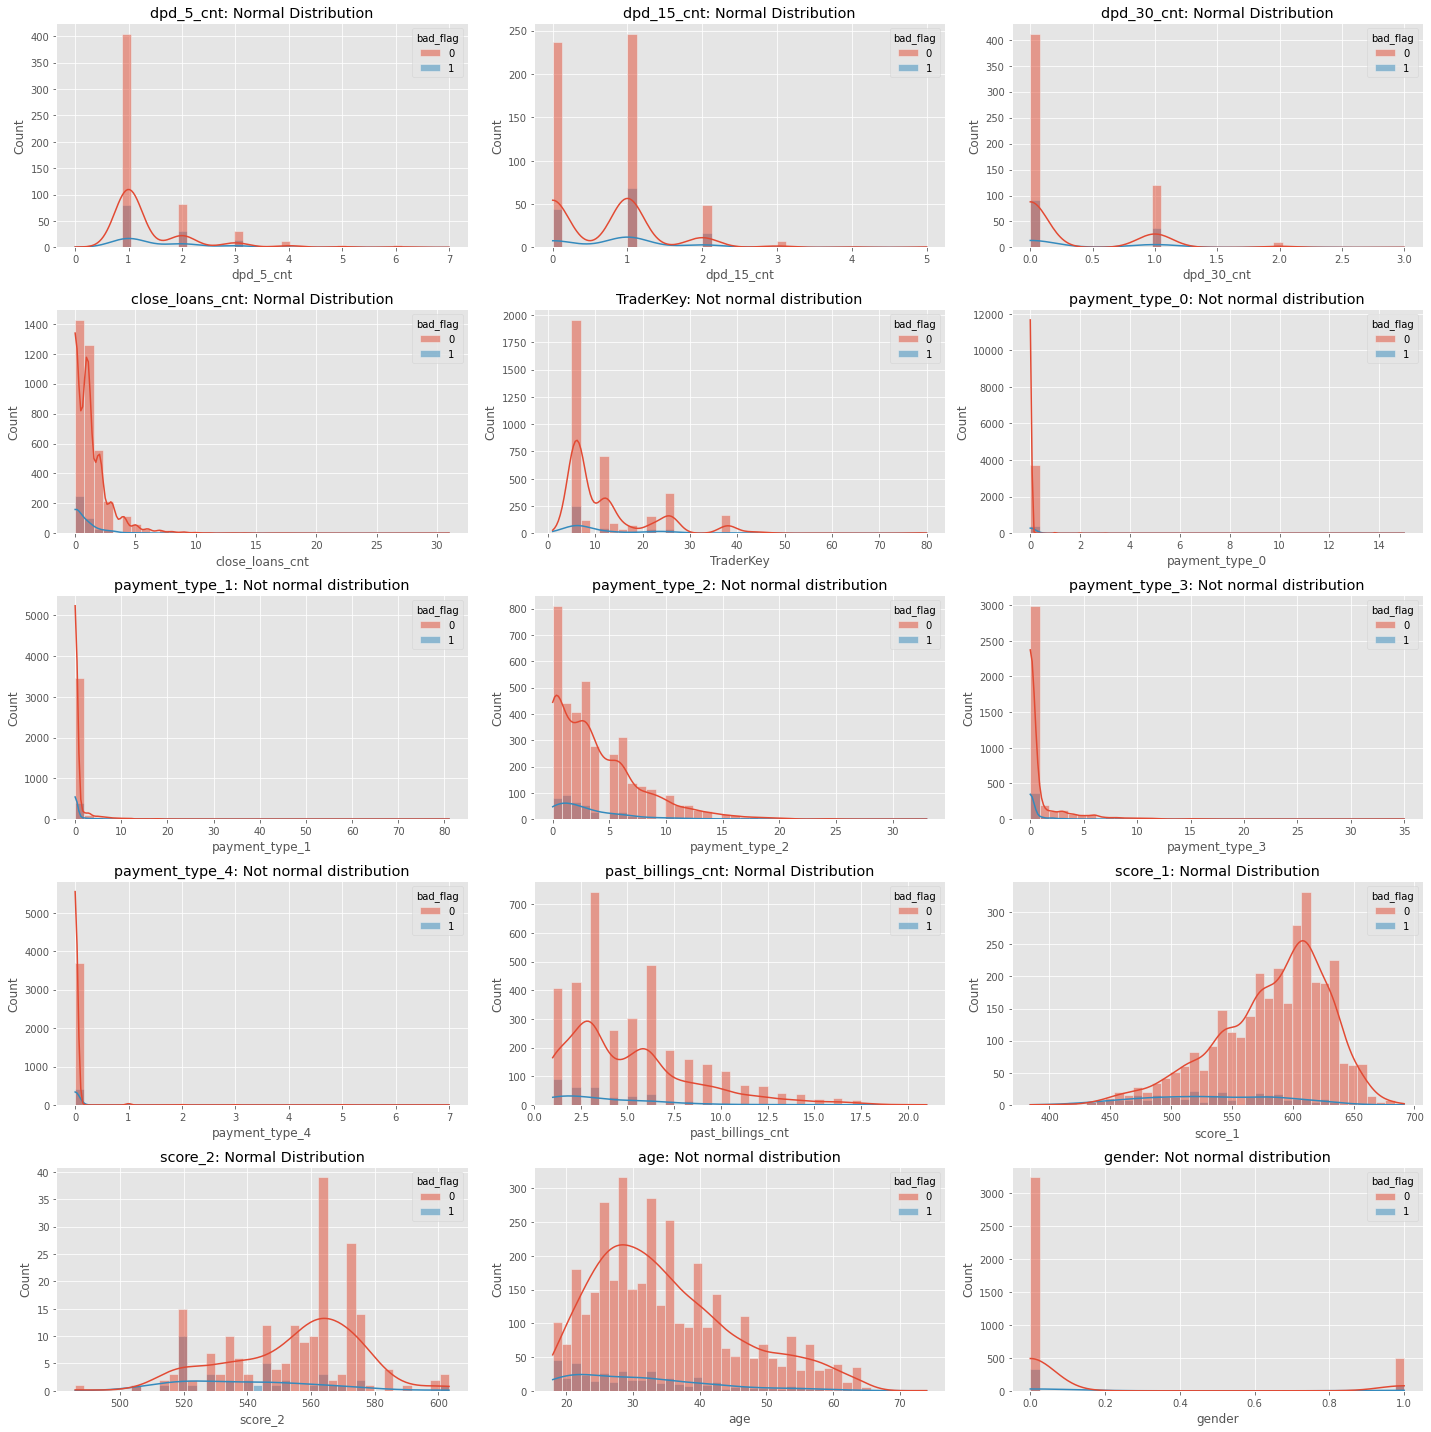

In [14]:
plt.figure(figsize=(20, 20))
for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 3, idx)
    dist = 'Normal Distribution' if stats.shapiro(df[column].sample(200, random_state=seed))[1] > 0.05\
                                                                                        else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
    sns.histplot(data=df, x=column, hue=TARGET, bins=40, kde=True)
plt.tight_layout()
plt.show()
# some features are skewed, having rare large values. Log or similar transforms may be applied
# nearly half of columns are drawn from normal distribution

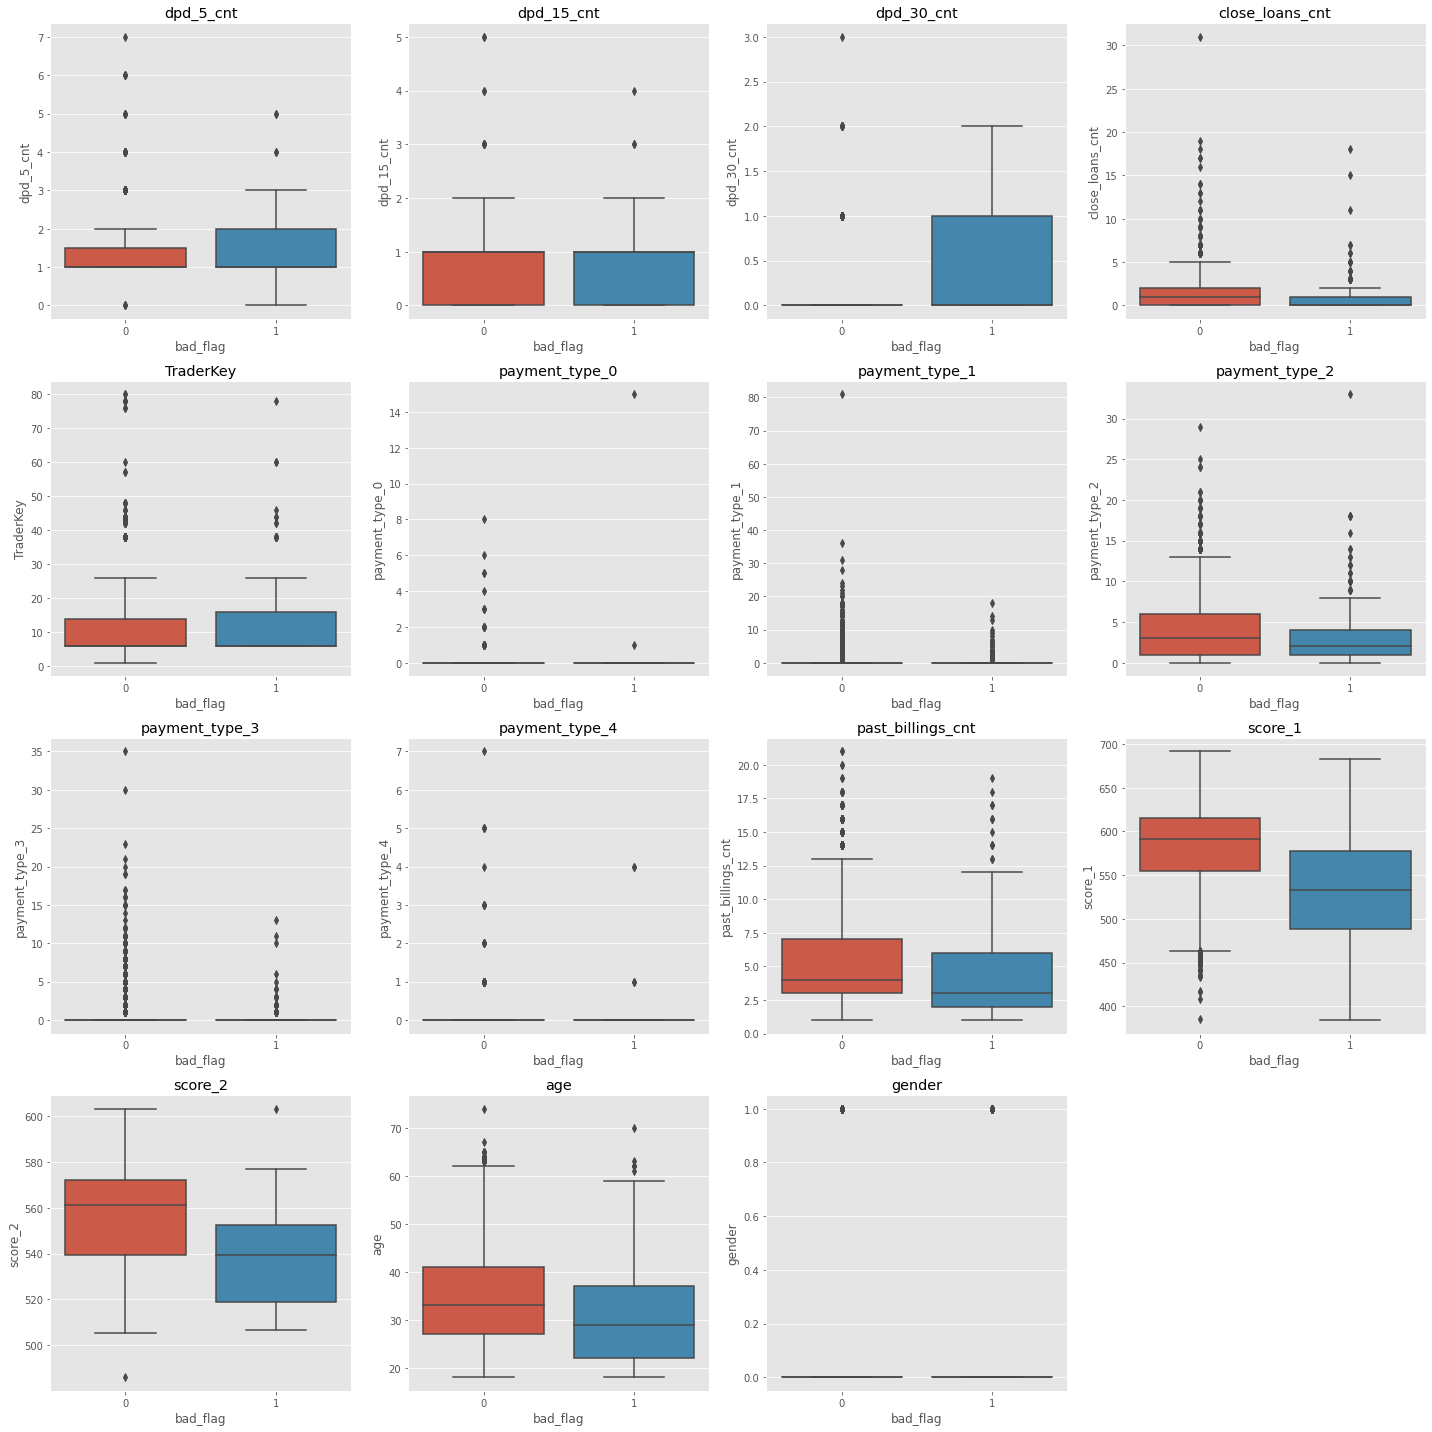

In [15]:
plt.figure(figsize=(20,20))
for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=df[column], x=df[TARGET], data=df)
    plt.title(f'{column}')
plt.tight_layout()
plt.show()
# lots of ouliers (look payment type 0,1,2): decide how to handle them later
# also: users with higher credit score are less prone to overdue, just like older ones and ones that closed loans more often
# the same picture for past billings count which is pretty obvious

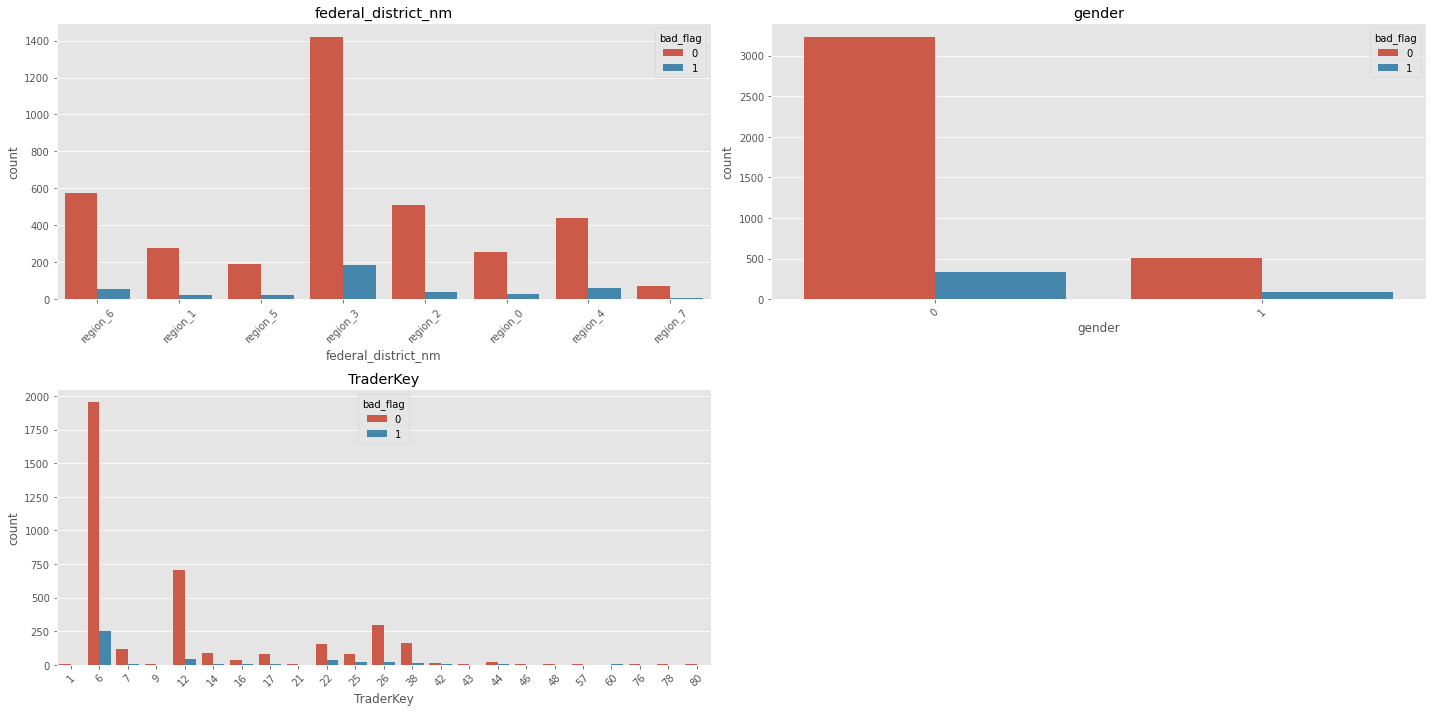

In [16]:
# fill federal_district_nm with most frequent value (small amount af nans)
df[categorical_columns[0]].fillna(df[categorical_columns[0]].mode()[0], inplace=True)
count_columns = [categorical_columns[0], 'gender', 'TraderKey']
plt.figure(figsize=(20, 10))
for idx, column in enumerate(count_columns, 1):
    plt.subplot(2,2, idx)
    plt.title(f'{column}')
    sns.countplot(x=column, hue=TARGET, data=df)
    plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

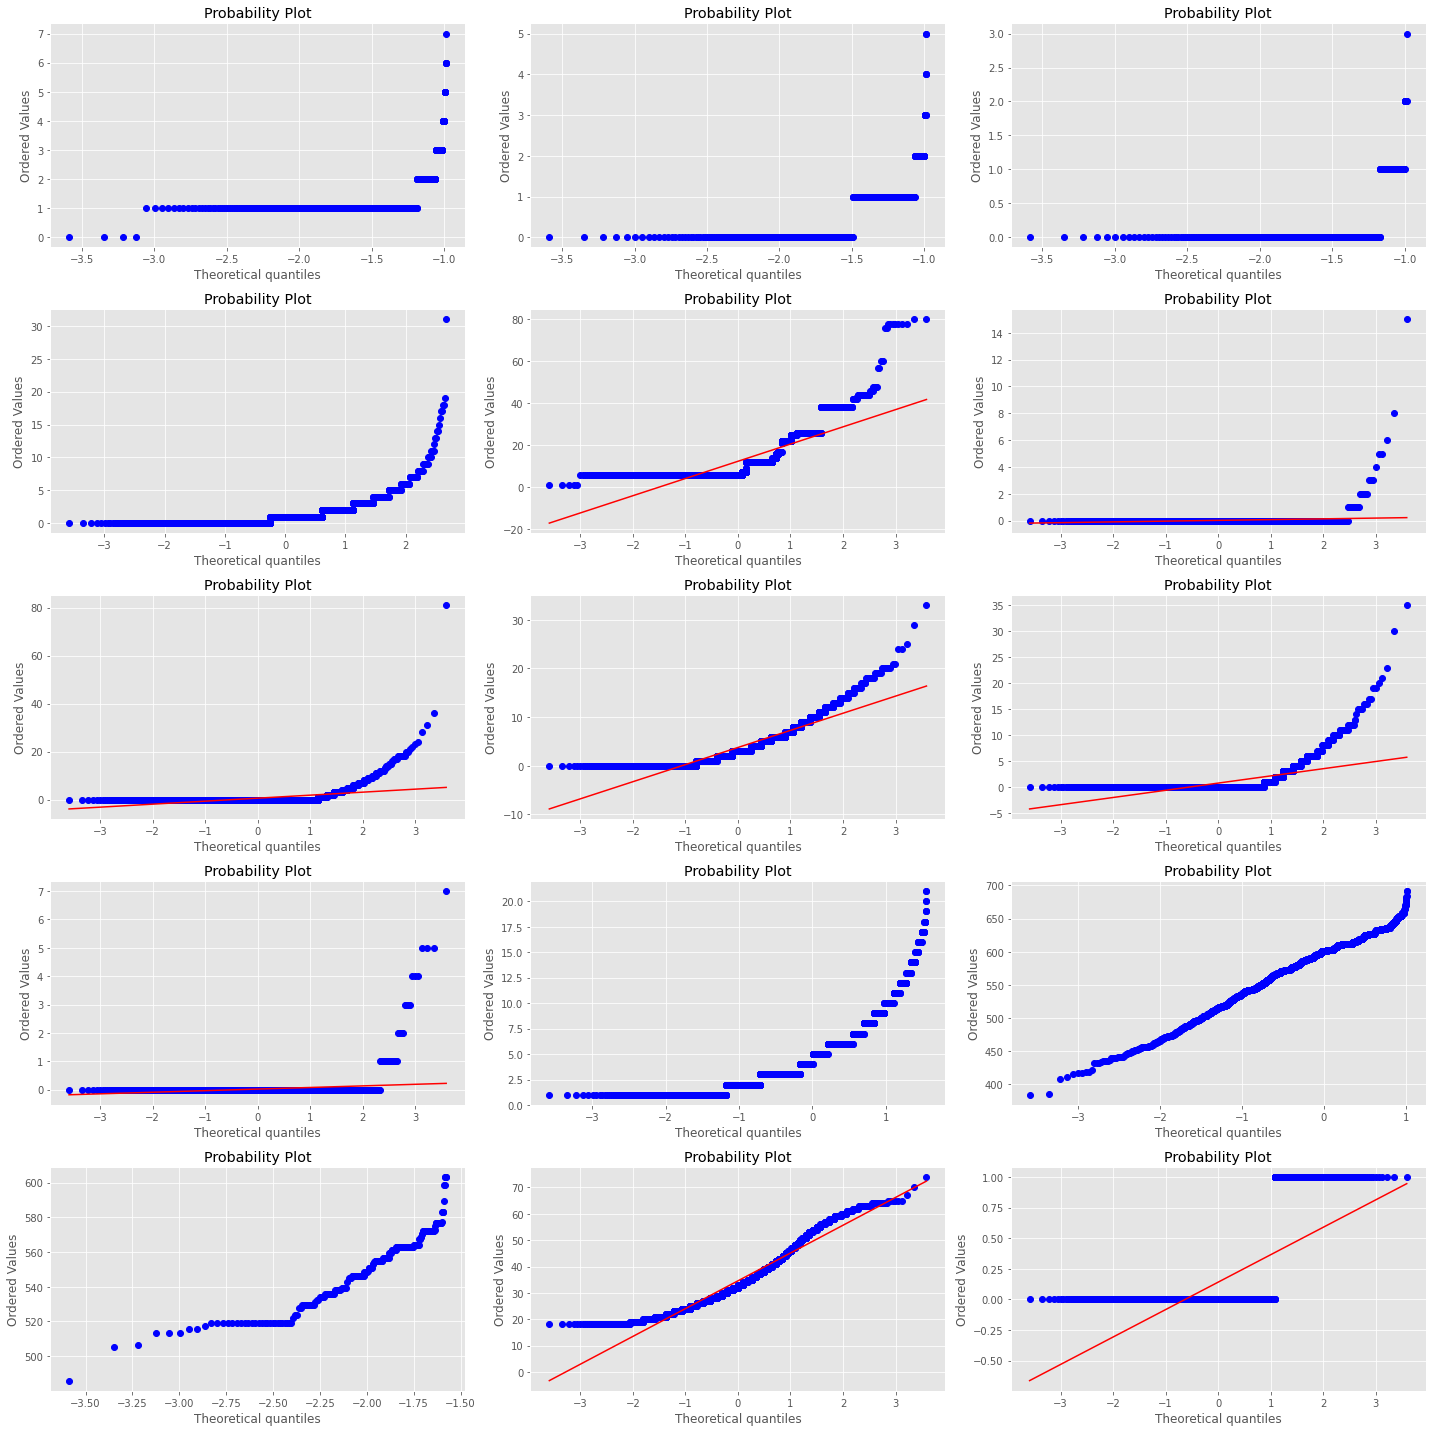

In [17]:
plt.figure(figsize=(20, 20))
for idx, column in enumerate(numerical_columns, 1):
    plt.subplot(5, 3, idx)
    plt.title(f'{column}')
    stats.probplot(df[column], plot=plt)
plt.tight_layout()
plt.show()

**Missing Values**
First of all find out the reason data is missing:

* Missing completely at random (MCAR): these are the missing data points that follow no discernable pattern and there is no option to predict or guess it's value using other variables;
* Missing at random (MAR): the data is missing due to, for example, measurement mistake. The missing value can roughly be interpolated from the remaining values to a reasonable degree of accuracy.
* Missing not at random (MNAR): Missing not at random or nonignorable data is data where the mechanism for why the data is missing is known. E.g. people do not like to tell about their income.
* Structurally Missing Data. These are data points that have reasons to be missing. E.g. credit score may occur missing for a person, who never loaned credit or interacted with financial organizations.

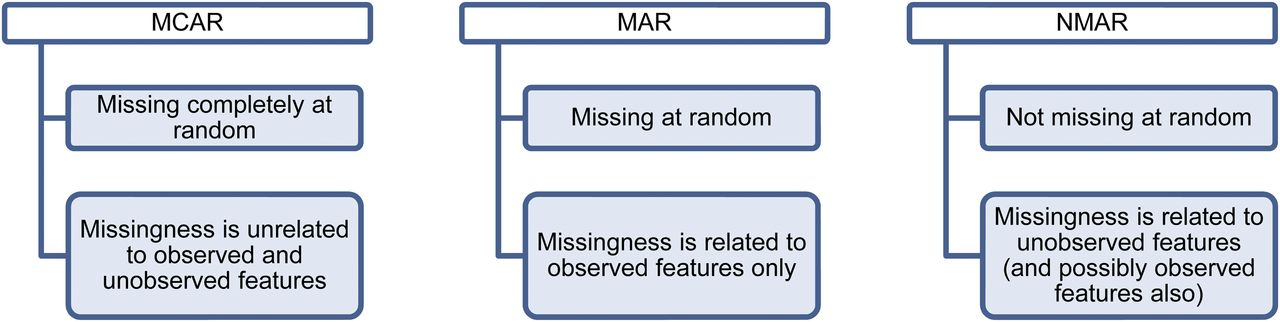

Depending on data knowledge these are common strategies of handling missing data:

* Drop feature if there are too many missing values (think of it in case > 50%) or create new category 'unknown' for categorical data;
* Drop rows (sample) with missing values if there are small amount of such rows;
* Interpolate nearest values of feature, e.g. mean value of previous and next data point (see also pandas interpolate method);
* Impute by mean, median, most frequent or some other resonable value (0, -1, etc.);
* use model ability to impute missing values, e.g. popular boosting models provide such option (Impute by min or max value guarantees that a split between missing values and other values is considered when selecting a new split in the tree);
* predict missing values like a regression task: $ Y_{nan} = F(X_{other})$, sklearn KNNImputer, IterativeImputer (MICE) is a great starting point for that.

Note: lots of missing values in feature do not always mean it undoubtedly need to be droped. Sometimes existing values may occur strong predictors, while it is possible to replace missing values with e.g. zero or some statistic.

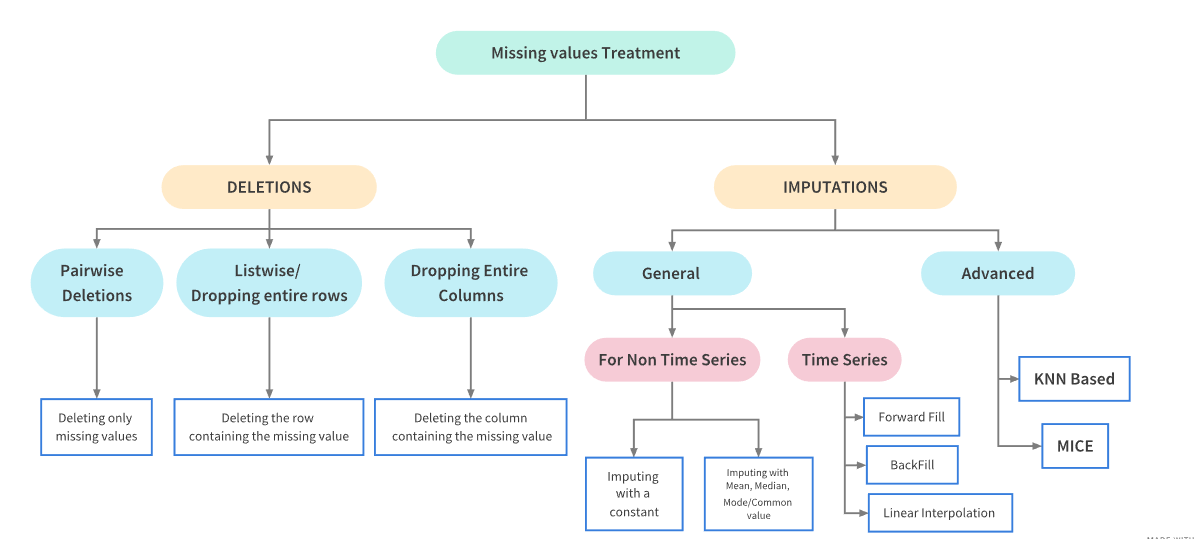

In [466]:
check_missings(df)

Total NA-values = 18770


dpd_5_cnt dpd_15_cnt dpd_30_cnt first_overdue_date close_loans_cnt  \
Total         3482       3482       3482               3482              15   
Percent  83.762329  83.762329  83.762329          83.762329        0.360837   
Types      float64    float64    float64             object         float64   

        federal_district_nm past_billings_cnt    score_1    score_2  
Total                    11               248        650       3918  
Percent            0.264614          5.965841  15.636276  94.250662  
Types                object           float64    float64    float64

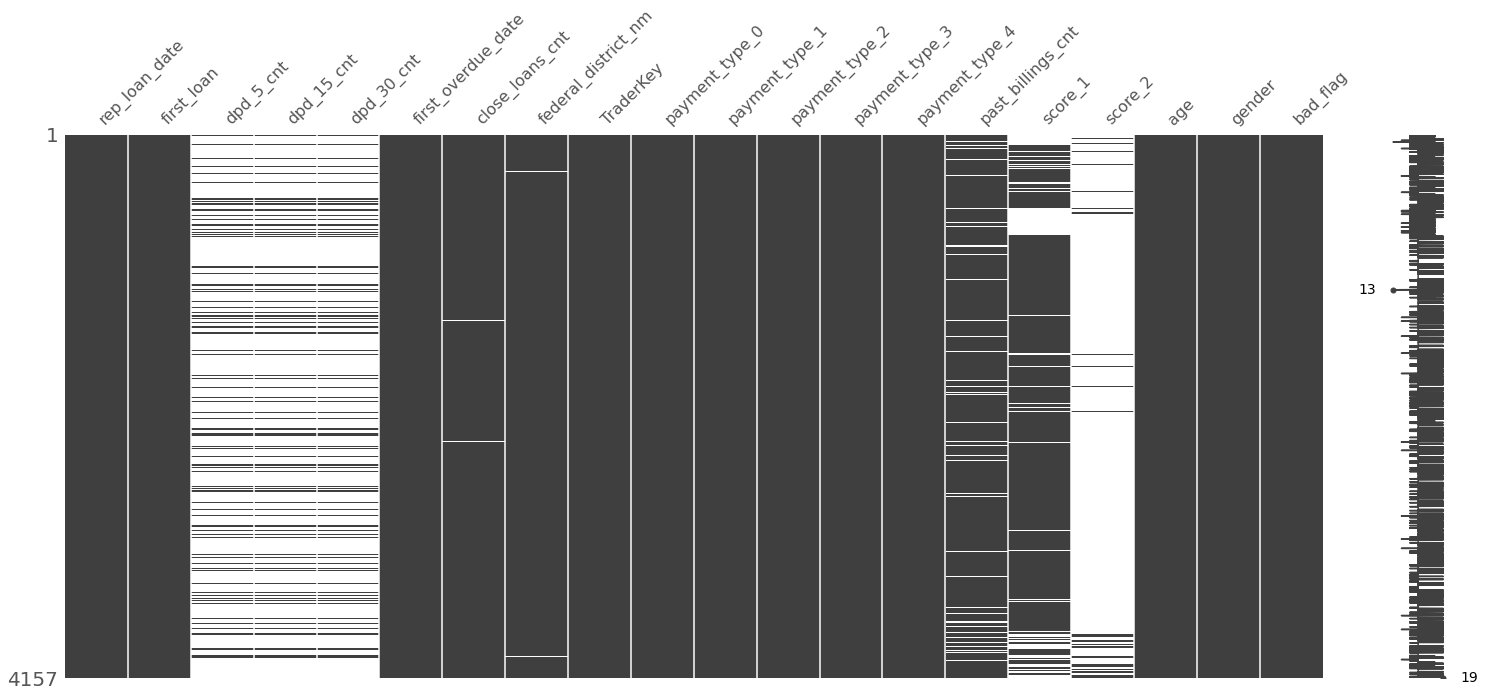

In [13]:
msg.matrix(df)
plt.show()
# fill dpd with 0, concatenate score_1 and score_2 and fill with 0, date = 0 after transforms, all other fill with 0 actually

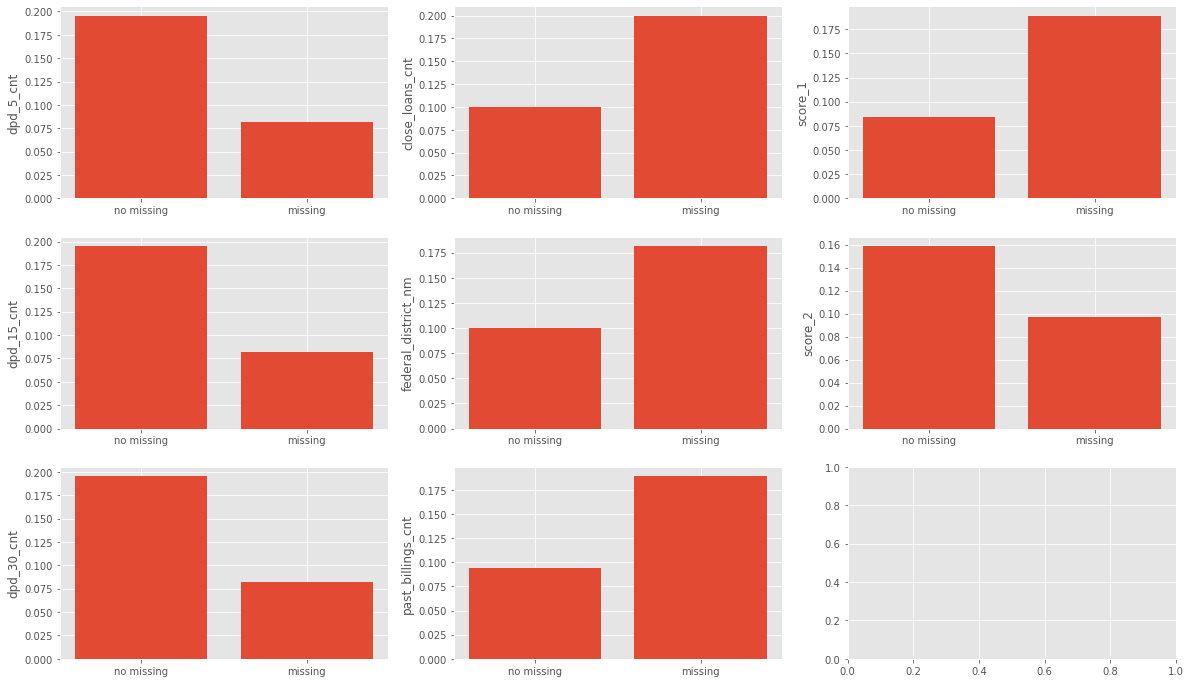

In [18]:
# identify whether missing features are missing at random: random = ~equal target mean (median)
features_with_na = [
    feature for feature in df.columns
    if df[feature].isnull().sum() > 1]

fig, axes = plt.subplots(3, 3, figsize=(20, 12))
for num, feature in enumerate(features_with_na):
    data = df.copy()
    data[feature] = np.where(data[feature].isnull(), 1, 0)
    statistics = data.groupby(feature)[TARGET].mean()  # median for regression
    axes[num%3, num//3].bar(statistics.index, statistics.values)
    axes[num%3, num//3].set_xticks([0, 1])
    axes[num%3, num//3].set_xticklabels(["no missing", "missing"])
    axes[num%3, num//3].set_ylabel(feature)
# it does not seem as values are missing at random: fill with 0 as no event

<AxesSubplot:>

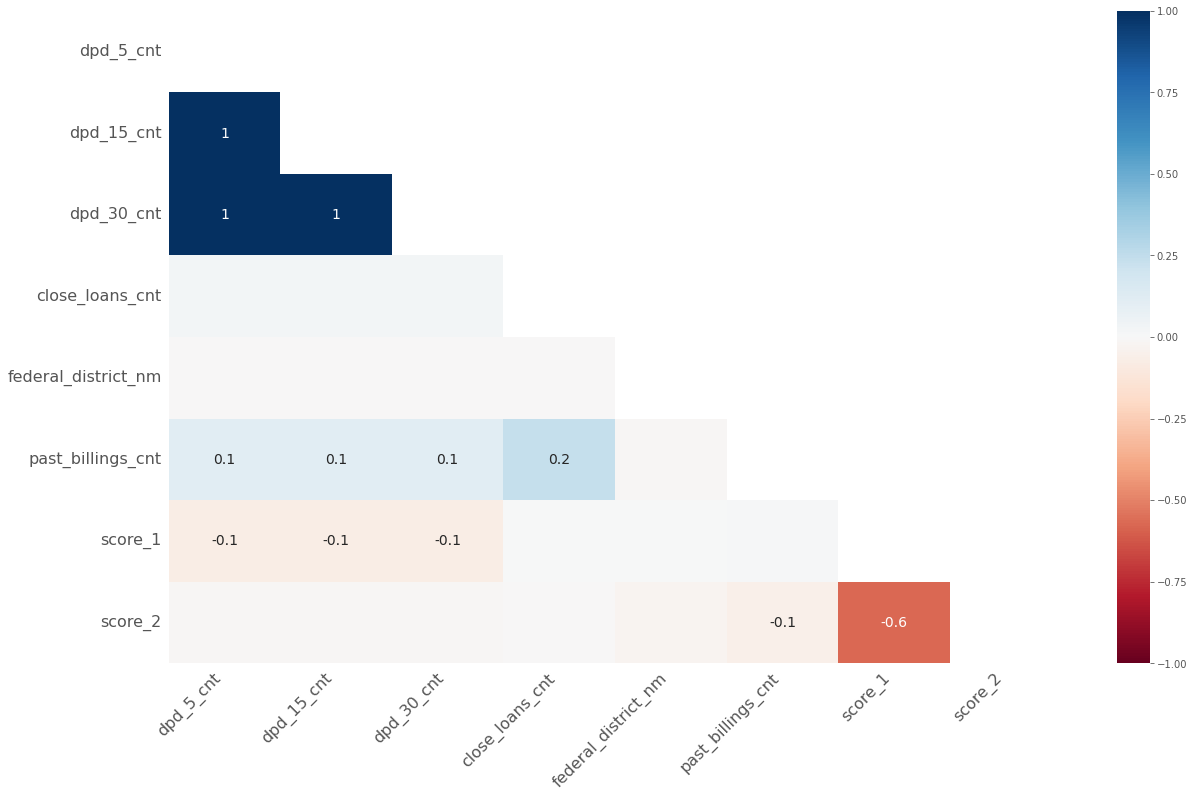

In [19]:
msg.heatmap(df)  # shows linear relationship between NaN values, the ones that close to -1 or 1 are not missing at random.
# correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects 
# the presence of another.
# also it is a good practice to check nan distributions on train\test to decide whether to drop nan column, 
# combine it with another or something else

**Heatmap shows linear relationships (Pearson correlation) between continous variables (Kendall, Spearman - non-linear)**

For linear models (LogisticRegression, SVM, etc.) having multicolinearrity between variables may have negative impact on model performance. To avoid such impact there are many ways to handle such correlation, for example:

* Drop one of the features, that highly (low < 0.3, medium - 0.3..0.66, high > 0.7) correlated to other and has lower impact on target variable;
* Transform such variables, e.g. multiply, take fraction $X_1$ * $X_2$, $X_1$/$X_2$, etc.;
* Apply Principal Component Analysis (PCA - linear unsupervised transformations that rotates original feature vectors in the direction of maximum variance) - which reduces the dimensionality, eliminate noise and linear correlation in given data. Note that such transforms do not make data more linearly separable - in such case apply non-linear transformations (e.g. KernelPCA).

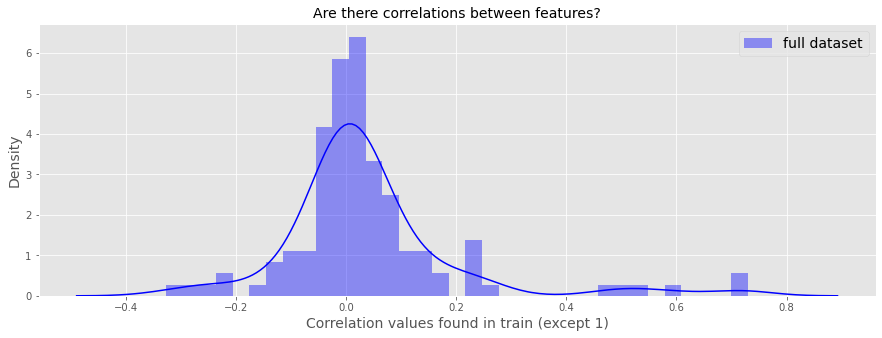

In [20]:
# build linear correlation heatmap
train_correlations = df.corr()
train_correlations = train_correlations.values.flatten()
train_correlations = train_correlations[train_correlations != 1]

columns = df.columns.tolist()
columns.remove(TARGET)

plt.figure(figsize=(15,5))
sns.distplot(train_correlations, color="Blue", label="full dataset")  # better to check on train/test 

plt.xlabel("Correlation values found in train (except 1)", size=14)
plt.title("Are there correlations between features?", size=14)
plt.legend(loc="best", fontsize=14)
plt.ylabel("Density", size=14)
plt.show()
# there are some correlations in right tail

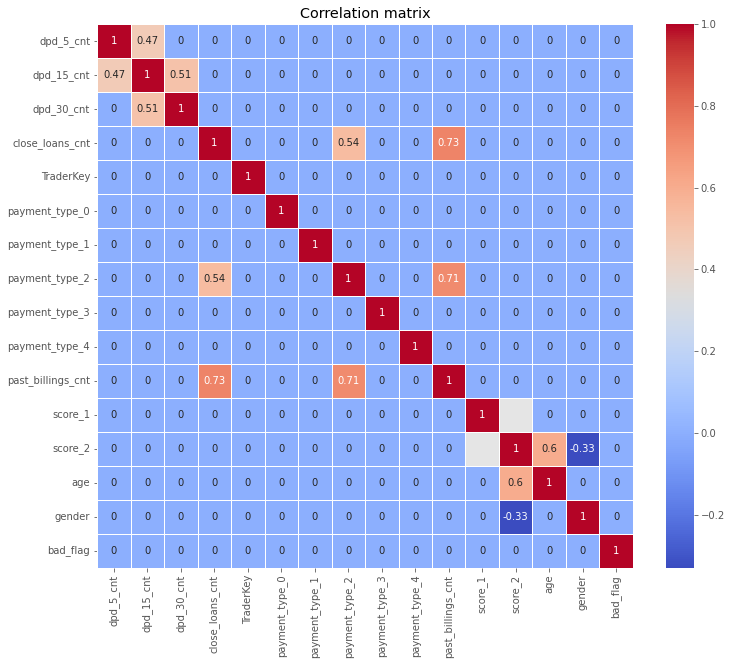

In [19]:
plt.figure(figsize = (12,10))
corr_matrix = df.corr()
corr_matrix = np.round(corr_matrix, 2)
corr_matrix[np.abs(corr_matrix) < 0.3] = 0  # not significant correlation
sns.heatmap(corr_matrix, annot=True, linewidths=.5, cmap='coolwarm')
plt.title('Correlation matrix')
plt.show()
# high correlation between past_billings_cnt, close_loans_cnt, payment_type_2: add some features in FE step

**Search and handling outliers**

Outlier - an observation that lies an abnormal distance from other values in a random sample from a population.

Outliers may lead (especially in linear models) to high bias in predictions and skew data distribution.

Common ways to look for outliers:

* Statistical methods, such as Z-score (where outlier is considered as value, that lies beyond 2 or 3 standard deviations $\sigma$, assuming data is close to normal distribution), IQR (inter quartile range) score (where outlier considered a point that lies beyond $Q_1 - 1.5\cdot(Q_3 - Q_1)$ and $Q_3 + 1.5\cdot(Q_3 - Q_1)$)
* Visual methods, such as boxplots (visualization of IQR), scatterplots;
* ML models, such as IsolationForest (‘isolates’ observations by randomly selecting a feature and then randomly selecting a split value between the maximum and minimum values of the selected feature, thus detecting anomalies), DBSCAN clustering (Any core sample is part of a cluster, by definition. Any sample that is not a core sample, and is at least $\epsilon$ in distance from any core sample, is considered an outlier by the algorithm).

Common methods to deal with outliers.

* Drop rows with outliers if there are small amount of them and such outliers considered as really anomally extreme values;
* In purpose not to loose information (especially with robust models) create new binary (or categorical/ordinal in case of: oridinal, large, extreme categories are present) feature that indicates whether a data point is outlier or not;
* Clip such features, e.g. by IQR score (or IQR + some value to highlight such observations), clip by 1 and 99 percentile (2.5 and 97.5);
* rank feature values (scipy.rankdata), which sorts column and uses indexes instead of feature value. So outlier is shifted closer to the mean of feature distribution. Always rank on train+test data;
* Replace with statistical value (median is better);
* Correct the value, e.g. when credit score is 5500, probably, deviding that value by 10 would make the data point resonable;
* Impute such data points as if they were missing (see missing data block);
* Transform such features: skewed data distribution may be transformed by applying $log$, $sqrt$ or more complex ways, e.g. PowerTransform from sklearn (‘yeo-johnson’, ‘box-cox’). All these transforms make data closer to normal distribution and may help eliminating in some cases the impact of outliers;
* Create new feature to flag (mark) the existing outlier (0, 1) or (0,1,2, where 2 - extreme category).

Outliers can be bad for boosting because boosting builds each tree based on previous tree s residuals/errors. Thus, outliers would have much larger residuals than non-outliers (large gradient). Sp gradient boosting would focus a disappropriate amount of its attention on those data points. As predicting residual is regression task outlier would impact on estimated leaf mean raw value. On the other hand large outliers do not impact on tree growth as they are not involved in node splits (being max or min values). So it is better to deal with extreme outliers or not take them into account while building trees or inference...

In [ ]:
# Isolationforest

In [20]:
clf = IsolationForest(n_estimators=100, 
                      contamination=0.001, # small value to take into account only significant outliers
                      random_state=seed, 
                      bootstrap=True,
                      n_jobs=-1).fit(df[numerical_columns].fillna(0))
outliers = clf.predict(df[numerical_columns].fillna(0))

In [21]:
df[outliers == -1]

rep_loan_date first_loan  dpd_5_cnt  dpd_15_cnt  dpd_30_cnt  \
loanKey                                                               
869848     2016-12-25 2015-06-27        2.0         2.0         2.0   
848750     2016-12-09 2015-09-11        2.0         2.0         1.0   
843366     2016-12-04 2015-03-24        3.0         2.0         1.0   
741557     2016-10-18 2015-04-29        4.0         4.0         2.0   
733104     2016-10-15 2015-03-15        5.0         4.0         2.0   

        first_overdue_date  close_loans_cnt federal_district_nm  TraderKey  \
loanKey                                                                      
869848          2016-05-30              6.0            region_4         26   
848750          2016-05-14              6.0            region_0          6   
843366          2015-10-02              6.0            region_3         38   
741557          2016-01-30             15.0            region_6         12   
733104          2015-06-20              5.0            region_3          6   

         payment_type_0  payment_type_1  payment_type_2  payment_type_3  \
loanKey                                                                   
869848                0               7               0              11   
848750                0               0               1              20   
843366                0               0              12               8   
741557                0               0              33               0   
733104                0               0               8               8   

         payment_type_4  past_billings_cnt     score_1  score_2   age  gender  \
loanKey                                                                         
869848                0               17.0         NaN      NaN  21.0       0   
848750                0               14.0         NaN      NaN  18.0       0   
843366                0               20.0  519.318136      NaN  18.0       0   
741557                0               16.0  619.655855      NaN  39.0       0   
733104                0               17.0  572.696647      NaN  23.0       0   

         bad_flag  
loanKey            
869848          1  
848750          0  
843366          0  
741557          1  
733104          0

In [ ]:
# maybe smooth outliers by applying log before feature selection step as outliers do not seem to be extreme

**Tests on equality**

It is a good approach to apply statistical test to find out is there statistically significant difference between two distributions ($P(y=0|x_i)$ and $P(y=1|x_i)$), e.g. importance of feature as target predictor or check up the train/test data split. For that purpose the most common tests are:
* The Shapiro-Wilk test tests the null hypothesis that the data was drawn from a normal distribution;
* Student T-test, assuming data follows normal distribution (or have enoogh samples to ignore that limitation). The t-test quantifies the difference between the arithmetic means of the two samples;
* The Mann-Whitney U test is a nonparametric test of the null hypothesis that the distribution underlying sample x is the same as the distribution underlying sample y.
* $\chi^2$ for the hypothesis test of independence of the observed frequencies in the contingency table.

In [22]:
# create total score
df['score'] = 0
df.loc[~df['score_1'].isna(), 'score'] = df.loc[~df['score_1'].isna(), 'score_1']
df.loc[~df['score_2'].isna(), 'score'] = df.loc[~df['score_2'].isna(), 'score_2']

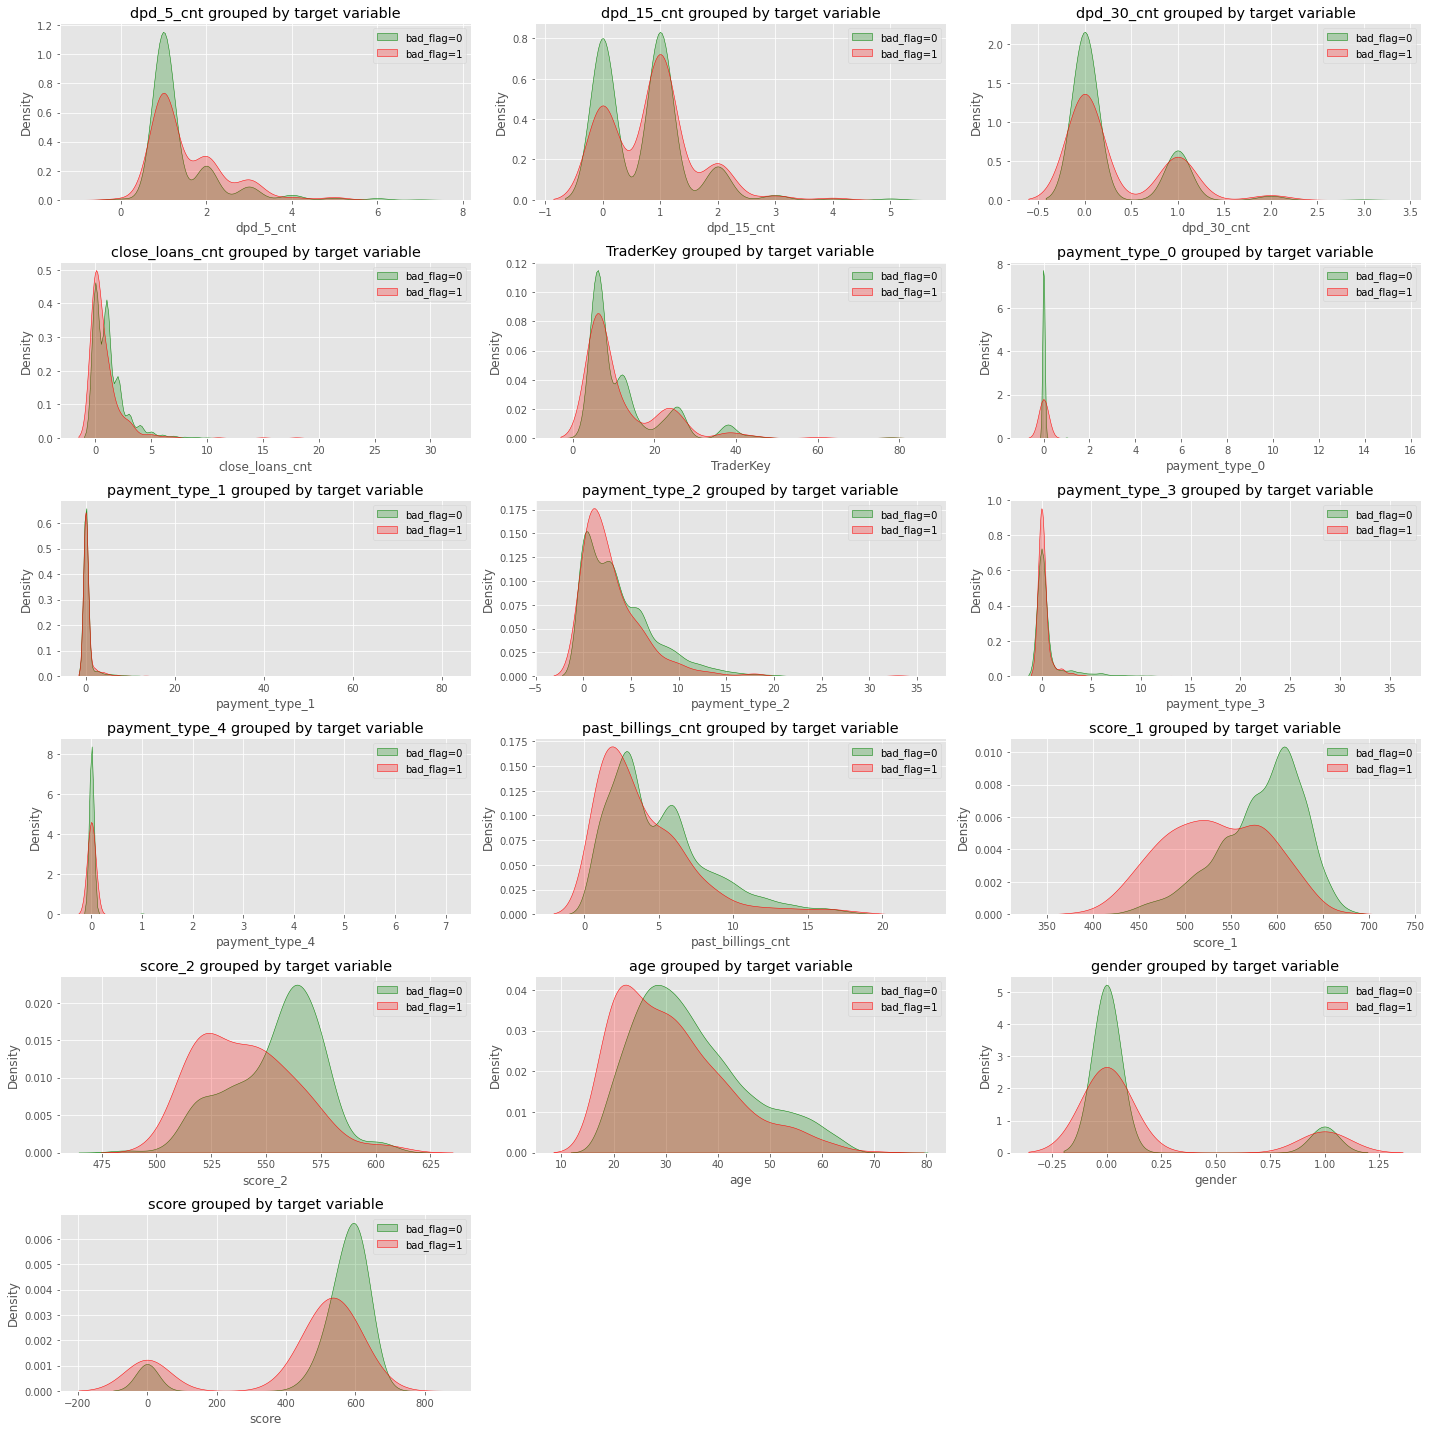

In [23]:
plt.figure(figsize=(20, 20))
for idx, column in enumerate(numerical_columns + ['score'], 1):
    plt.subplot(6, 3, idx)
    feature_with_target_s = df[[column, TARGET]]
    feature_s = feature_with_target_s[column]
    feature_target_0 = feature_s[feature_with_target_s[TARGET] == 0]
    feature_target_1 = feature_s[feature_with_target_s[TARGET] == 1]
    sns.kdeplot(feature_target_0, shade=True, label=f'{TARGET}=0', color='g')
    sns.kdeplot(feature_target_1, shade=True, label=f'{TARGET}=1', color='r')
    plt.xlabel(column)
    plt.title(f'{column} grouped by target variable')
    plt.legend(loc='best')
plt.tight_layout()
plt.show()

In [24]:
# inspect numerical features on whether they are statistically strong
statistic_output(*numerical_columns, 'score', sample_size=100)
# not what expected to see

Factor "dpd_5_cnt" does not affect target.
Factor "dpd_15_cnt" does not affect target.
Factor "dpd_30_cnt" does not affect target.
Factor "close_loans_cnt" does not affect target.
Factor "TraderKey" does not affect target.
Factor "payment_type_0" does not affect target.
Factor "payment_type_1" has statistical impact on target (var_a: 1.17, var_b: 5.93).
Factor "payment_type_2" does not affect target.
Factor "payment_type_3" does not affect target.
Factor "payment_type_4" has statistical impact on target (var_a: 0.10, var_b: 0.12).
Factor "past_billings_cnt" does not affect target.
Factor "score_1" does not affect target.
Factor "score_2" does not affect target.
Factor "age" does not affect target.
Factor "gender" does not affect target.
Factor "score" has statistical impact on target (var_a: 25788.55, var_b: 62235.61).


In [25]:
categorical_stats(sample_size=200)
# looks like almost all features are statistically weak

federal_district_nm
Statistically weak categorical features:  federal_district_nm


In [470]:
calculate_feature_separating_ability(df.select_dtypes(exclude=np.object).drop(TARGET, axis=1), df[TARGET])
# first look into feature importances (initial numeric columns) by gini metric

dpd_5_cnt            0.177258
dpd_15_cnt           0.176610
dpd_30_cnt           0.174509
gender               0.064281
score_2              0.035486
payment_type_1       0.013003
payment_type_5       0.000000
payment_type_4      -0.000283
payment_type_0      -0.002148
TraderKey           -0.065704
payment_type_3      -0.072970
payment_type_2      -0.113832
loanKey             -0.210584
close_loans_cnt     -0.221127
age                 -0.224088
past_billings_cnt   -0.238392
score_1             -0.460911
dtype: float64

**Categorical features handling**

Common types of categorical feature encoding:

* One-hot encoding: useful (especially for linear models) when categorical feature has low cardinality (number of unique values) and there are enough samples in dataset: num_samples > $2^k\cdot10$, where k is number of unique categorical values, 2 - means binary feature. OHE is not the best choice for tree-based models, but may be fine for linear. OHE with high cardinality makes tree-models artificially use them more often, thus assuming them as important, which is not necessary true, so we get more splits and deeper tree - overfitted;
* LabelEncoder - very straightforward, simple yet effective for boosting, way to encode categorical data. Adds randomness, samples with close values are more similar, which is actually not. It is hard for non-tree models to learn non-linear relationships;
* before making one-hot encoding it is good practice to find out whether it is possible to union any categories in case of high feature cardinality;
* K-Fold mean target encoding regularization. $label_c = \frac{p_c\cdot n_c + p_g \cdot \alpha}{n_c + \alpha}$, where $p_c$ - mean target for current category, $n_c$ - number of samples from that category, $p_g$ - mean target for all data, $\alpha$ - hyperparamter. To reduce the impact of overfitting: split data in 3-6 folds, calculate $label_c$ for every sample except fold with current example. CatBoost developers state that such method also has predicton shift and propose to encode using ordered method, where target statistics for i-th sample is calculated on samples with indices 0..i-1 (permute variable multiple times and repeat);
* In case of high cardinality to avoid the 'curse' of dimensionality (when huge number of features has crucial impact on model performance, especially on linear or distance-based models: knn, logreg, svm; also tree-based models can suffer a lot - the whole tree may be built on OHE categories without other variables - thus we get overfitting) - it is preferred to apply target or other encodings, for numerious types of sklearn-optimized encodings see: [Category encoders](https://contrib.scikit-learn.org/category_encoders/);
* check if categorical feature has some order (e.g. flight-class: economy, business, first, etc.): if simply encode as integer value we would loose information about gap between categories (economy cost << buisiness cost), i.e. the model would treat such categories as equally distanced. Better here to use encoding even if cardinality is low;
 
For example, catboost developers suppose that target encoding (where permutation and $Stat(samples_{i-k})$ for i-th sample is calculated multiple times) performs better than one-hot ([catboost encoding](https://catboost.ai/en/docs/concepts/algorithm-main-stages_cat-to-numberic)).

In [26]:
categorical_output('federal_district_nm')  # 6,4,1,2,0
print(df['federal_district_nm'].unique())

federal_district_nm
Categories region_6 and region_1 can be united. P-value: 0.3085
Categories region_6 and region_5 can be united. P-value: 0.8924
Categories region_6 and region_3 can be united. P-value: 0.2262
Categories region_6 and region_2 can be united. P-value: 0.7778
Categories region_6 and region_0 can be united. P-value: 0.4864
Categories region_6 and region_4 have different frequencies with target, p-value: 0.0032.
Categories region_6 and region_7 can be united. P-value: 0.8046
Categories region_1 and region_5 can be united. P-value: 0.2316
Categories region_1 and region_3 can be united. P-value: 0.6650
Categories region_1 and region_2 can be united. P-value: 1.0000
Categories region_1 and region_0 can be united. P-value: 0.8748
Categories region_1 and region_4 have different frequencies with target, p-value: 0.0127.
Categories region_1 and region_7 can be united. P-value: 0.2209
Categories region_5 and region_3 can be united. P-value: 0.8071
Categories region_5 and region_2

In [23]:
# create dummy variables, left categorical encoding for catboost inbuilt algorithm
df = pd.get_dummies(df, prefix=['federal_district_nm'], drop_first=True)

In [24]:
# finally remove nans
df.fillna(0, inplace=True)

#### Some additional plots

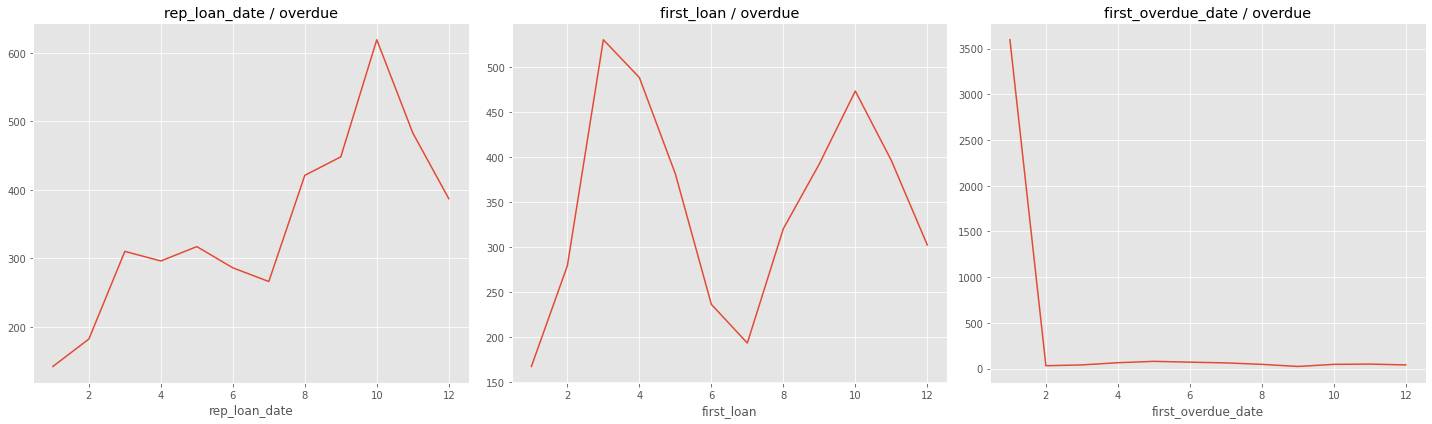

In [29]:
tmp_data = df[[TARGET, 'rep_loan_date', 'first_loan', 'first_overdue_date']].copy()
tmp_data['rep_loan_date'] = tmp_data['rep_loan_date'].dt.month
tmp_data['first_loan'] = tmp_data['first_loan'].dt.month
tmp_data['first_overdue_date'] = tmp_data['first_overdue_date'].dt.month

plt.figure(figsize=(20,6))
for i, column in enumerate(tmp_data.columns[1:], 1):
    plt.subplot(1, 3, i)
    plt.title(f'{column} / overdue')
    tmp_data.groupby(column)[TARGET].count().plot()
plt.tight_layout()
plt.show()
# users loan mostly in october, first loan also march
# overdue is anomalous high in january after new year - it is because of '1970-01-01' there is no overdue (were nans)

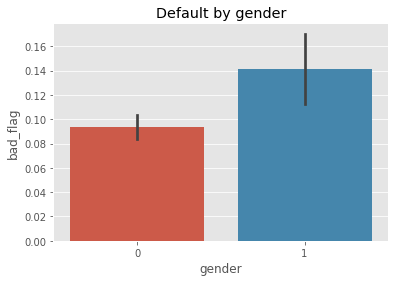

In [30]:
plt.title('Default by gender')
sns.barplot(x='gender', y=TARGET, data=df)
plt.show()
# gender = 1 is most prone to default

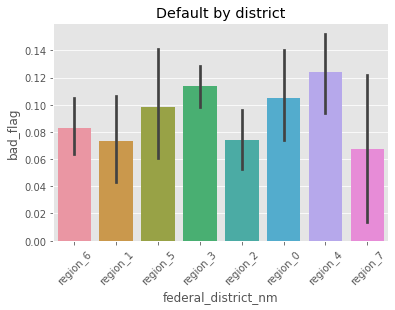

In [31]:
dff = pd.read_csv(path)
plt.title('Default by district')
sns.barplot(x='federal_district_nm', y=TARGET, data=dff)
plt.xticks(rotation=45)
plt.show()
# region 4 is most defaulted

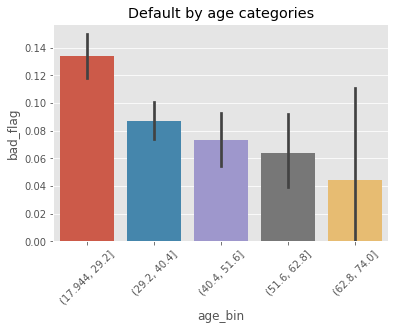

In [32]:
dff['age_bin'] = pd.cut(dff['age'], bins=5)
plt.title('Default by age categories')
sns.barplot(x='age_bin', y=TARGET, data=dff)
plt.xticks(rotation=45)
plt.show()
# young people overdue more often, but some old people also overdue (watch the tail)

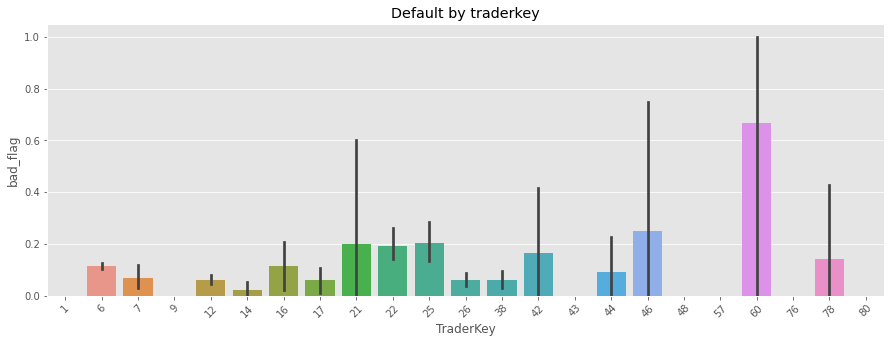

In [33]:
plt.figure(figsize=(15, 5))
plt.title('Default by traderkey')
sns.barplot(x='TraderKey', y=TARGET, data=dff)
plt.xticks(rotation=45)
plt.show()
del dff
# trader key = 60 is most defaulted, 9,48,57 less defaulted

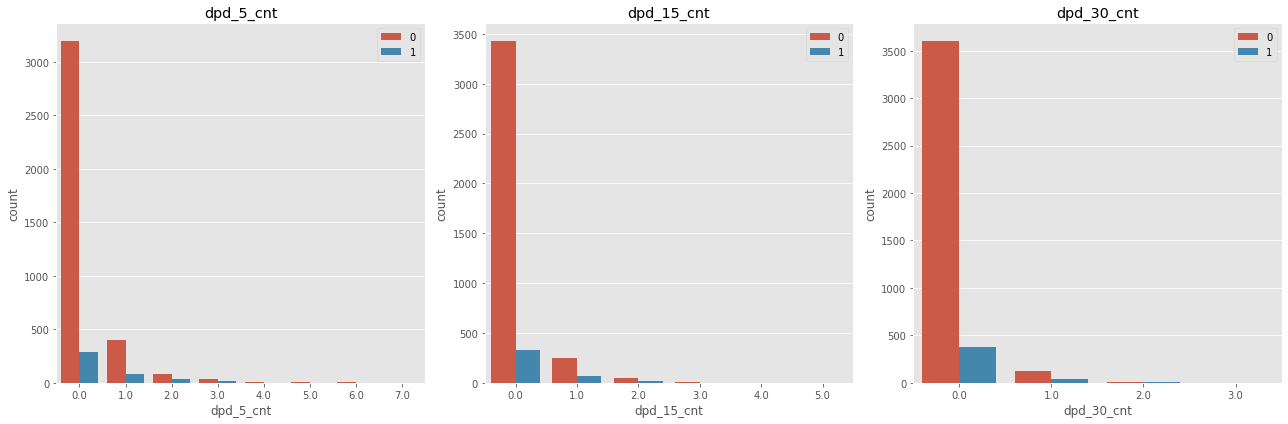

In [34]:
plt.figure(figsize=(18, 6))
for i, column in enumerate(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt'], 1):
    plt.subplot(1,3,i)
    plt.title(f'{column}')
    sns.countplot(x=column, hue=TARGET, data=df)
    plt.legend(loc='upper right')
plt.tight_layout()
plt.show()

**Feature Engineering**

Feature engineering is a machine learning technique that leverages data to create new variables that aren't in the training set. This process can help the selected model to learn some important dependencies from given data, that are unreachable with initial features due to model limitations (e.g. linear model cannot learn non-linear relationships).

Some common ways (except featuretools python module):
* Multiplies, sums, divisions (including PolynomialFeatures, which is great tool for linear models);
* Ratios / Divisions;
* Grouping / subgrouping categories by mean, median, counts of corresponding subsets of other features or target (beware of target/data leakage - consider how not to include training data in test set);
* Counts (counts, sums of actions, payments, etc.), which is good practice for boosting models;
* Sums, totals, means, stds (also weighted if there is time or some space dependency) of subsets of features;
* Bins, cuts of numerical features (e.g. age, payments, income, etc.);
* Flags;
* categorical features combinations, e.g. all unique interactions berween two variables (df.cat1 + '|' + df.cat2). This adds stability to tree-based models and helps to perform faster splits in tree nodes, thus reducing depth and complexity of tree;
* External features - data available in real life (e.g. mortality in certain country in given period when predicting medical diagnoses);
* Any types of embeddings - lower space representations of numerical data;
* lags, rolling windows, fourier transforms, days, month, timedeltas etc. for time-series or time-dependent data;
* log, sqrt, exponential transformations of one or multiple features;
* BoW, word2vec, tf-idf, TF TextVectorizer, other tokenizers+vectorizers - after text cleaning, stemming/lemmatization if needed (or use inbuilt abilities, e.g. catboost text_features or cat_features - that also searches for combinations of categorical features with max_ctr_complexity parameter);
* Secondary feautures, i.e. combine engineered features (e.g. construct salary to credit_annuity ratio and than make flag where this ratio is higher some threshold).

Note, that for every type of ML model it is necessary to perform (adapt) preprocessing and feature engineering with respect to their strong parts.

In [25]:
# transforms that are not dependent from data split

df['rep_loan_date_year'] = df['rep_loan_date'].dt.year
df['rep_loan_date_month'] = df['rep_loan_date'].dt.month
df['rep_loan_date_day'] = df['rep_loan_date'].dt.day

df['first_loan_year'] = df['first_loan'].dt.year
df['first_loan_month'] = df['first_loan'].dt.month
df['first_loan_day'] = df['first_loan'].dt.day

df['first_overdue_date_year'] = 0  # remove 1970-01-01
df['first_overdue_date_month'] = 0
df['first_overdue_date_day'] = 0
condition = (df['first_overdue_date'] != '1970-01-01')
df.loc[condition, 'first_overdue_date_year'] = df.loc[condition, 'first_overdue_date'].dt.year
df.loc[condition, 'first_overdue_date_month'] = df.loc[condition, 'first_overdue_date'].dt.month
df.loc[condition, 'first_overdue_date_day'] = df.loc[condition, 'first_overdue_date'].dt.day

In [26]:
df['loan_rep_loan_diff'] = (df['rep_loan_date'] - df['first_loan']).dt.days
df['loan_over_diff'] = (df['first_overdue_date'] - df['first_loan']).dt.days
df.loc[df['loan_over_diff'] < 0, 'loan_over_diff'] = 0

df['rep_over_diff'] = (df['rep_loan_date'] - df['first_overdue_date']).dt.days
df.loc[df['rep_over_diff'] > 1000, 'rep_over_diff'] = 0

In [27]:
df['payment_sum'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']].sum(axis=1)
df['payment_sum_log'] = np.log(df['payment_sum']+1)

df['payment_mean'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']].mean(axis=1)
df['payment_std'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 'payment_type_3', 'payment_type_4']].std(axis=1)

df['payment_type_0_log'] = np.log(df['payment_type_0']+1)
df['payment_type_1_log'] = np.log(df['payment_type_1']+1)
df['payment_type_2_log'] = np.log(df['payment_type_2']+1)

In [28]:
df.drop(['rep_loan_date', 'first_loan', 'first_overdue_date'], axis=1, inplace=True)

In [29]:
df['age_bin'] = pd.cut(df['age'], [16,30,40,51,64,90], labels=['18-29', '30-40', '40-51', '52-63', '64+'])
df = pd.get_dummies(df, prefix=['age'])

df['close_bill_diff'] = df['close_loans_cnt'] - df['past_billings_cnt']
df['score_2_age_ratio'] = df['score_2'] / df['age']

In [272]:
# df1 = df.copy()
# df1['dpd_5_cnt'] = df1['dpd_5_cnt'].astype('category')
# df1['dpd_15_cnt'] = df1['dpd_15_cnt'].astype('category')
# df1['dpd_30_cnt'] = df1['dpd_30_cnt'].astype('category')

# df1 = pd.get_dummies(df1)

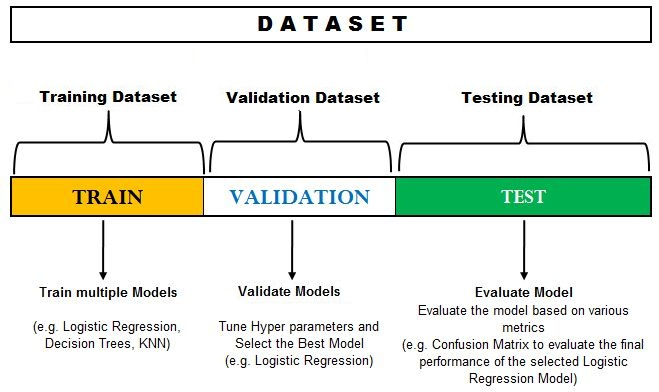

In [30]:
X, y = df.drop(TARGET, axis=1), df[TARGET]

X = reduce_memory_df(X)  # optimize memory usage

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)

Memory usage of dataframe is 1.25 MB
Memory usage after optimization is: 0.45 MB
Decreased by 63.9%


In [31]:
encoder = ce.cat_boost.CatBoostEncoder(random_state=seed)
X_train['trader_key_tar'] = encoder.fit_transform(X_train['TraderKey'].astype('category'), y_train)
X_test['trader_key_tar'] = encoder.transform(X_test['TraderKey'].astype('category'))

In [32]:
pay_loan_dict = X_train.groupby('payment_type_2')['close_loans_cnt'].mean().to_dict()
# create_numerical_aggs(X_train, 'payment_type_2', {'close_loans_cnt': ["mean"]}) + merge

X_train['pay_loan_2'] = X_train['payment_type_2'].map(pay_loan_dict)
X_test['pay_loan_2'] = X_test['payment_type_2'].map(pay_loan_dict)
X_test['pay_loan_2'].fillna(X_test['pay_loan_2'].mean(), inplace=True)

**Feature Selection**

Feature selection is the process of reducing the number of input variables when developing a predictive model. It is desirable to reduce the number of input variables to both reduce the computational cost of modeling and, in some cases, to improve the performance of the model by eliminating unnecessary noise.

Most common techniques:
* Statistical test, feature correlations, PCA (which is not feature selection method, but it can provide new features, ordered by max variance), inbuilt importancies (weights size for gradient descent models, information gain in random forests (features that are mostly increase node impurity), feature frequency in node splits in boosting (features that are most frequently used in node splits), etc.) - the main disadvantages: models should not be overfitted, only 1d relationships considered;
* Variance Threshold: removes all features whose variance doesn’t meet some threshold;
* Mutual information: Estimate mutual information for a target variable. MI between two random variables is a non-negative value, which measures the dependency between the variables. It is equal to zero if and only if two random variables are independent, and higher values mean higher dependency;
* Permutation importance: is defined to be the decrease in a model score when a single feature value is randomly shuffled. This procedure breaks the relationship between the feature and the target, thus the drop in the model score is indicative of how much the model depends on the feature;
* Univariate feature selection works by selecting the best features based on univariate statistical tests. Based on $\chi^2$-test, F-test or mutual information; 
* RFE: Given an external estimator that assigns weights to features (e.g., the coefficients of a linear model), the goal of recursive feature elimination is to select features by recursively considering smaller and smaller sets of features. Also consider great method from catboost - select_features, that recursively removes features, calculating loss decrease and feature importancies (e.g. shap-values);
* Sequntial Feature Selection: Forward-SFS is a greedy procedure that iteratively finds the best new feature to add to the set of selected features. There are forward and backward implementations;
* Sklearn SelectFromModel: great class (can be used in pipeline) that eliminates weak features according to feature importancies in tree-models or weights size in linear (gradient descent models). A good practice to combine SelectFromModel with LogisticRegression (with L1 penalty, which zeros weights of weak features) and tree-models at the end;
* Boruta and BorutaShap: iteratively uses so-called shadow features, importancies of features (e.g. inbuilt model importancies, permutation importancies or shap-values) with combination of T-test to mark features as 'hit' and 'no-hit' features. Then selects important ones. For algorithm details see: [BorutaShap implementation](https://pypi.org/project/BorutaShap/);
* Exhaustive methods: straightforward method, the most accurate, but also the most computationally expensive, that is why it is only good for small datasets. The method runs all possible subsets of data and choose best with respect to evaluation metric. So it need to build $\sum_{i=0}^{d}(d - i) = 231$ models, having 21 feature.

Note: most of approaches does not take into account feature interactions (i.e. dropping one weak feature may cause strong feature to become weak as they had common predictive power).

Note: good choice is removing noisy features at the start (e.g. by gini metric), than apply permutation importance to remove non-informative features, than apply more complex methods (boruta, recursive, which require more computational time).

As the given dataset is small - the exhaustive method can be applied. But for academic interest:

* for LogistiRegression and SVM - Exhaustive
* for RandomForest - SelectFromModel with lasso regularization
* for CatBoost - BorutaShap

In [33]:
class BestSet(BaseEstimator, TransformerMixin):
    def __init__(self, model, k_features=10, scoring=f1_score, test_size=0.2):
        self.scoring = scoring
        self.k_features = k_features
        self.test_size = test_size
        self.model = model

    def fit(self, X, y):
        X_train, X_test, y_train, y_test = train_test_split(X,
                                                            y, 
                                                            test_size=self.test_size, 
                                                            stratify=y,
                                                            random_state=seed)
        dim = X_train.shape[1]
        self.indices_ = tuple(range(dim))
        self.subsets_ = [self.indices_]
        score = self._calc_score(X_train, y_train, X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores, subsets = [], []
            for p in tqdm(combinations(self.indices_, r=dim-1), total=dim, leave=False):
                score = self._calc_score(X_train, y_train, X_test, y_test, p)
                scores.append(score)
                subsets.append(p)
            best = np.argmax(scores)
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1
            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]
        return self
    def transform(self, X):
        best_indices = self.subsets_[np.argmax(self.scores_)]
        return X[:, best_indices]

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        self.model.fit(X_train[:, indices], y_train)
        y_pred = self.model.predict(X_test[:, indices])
        score = self.scoring(y_test, y_pred)
        return score

In [34]:
estimator = make_pipeline(MinMaxScaler(), LogisticRegression(class_weight='balanced', random_state=seed, n_jobs=-1))
selector = BestSet(model=estimator, scoring=f1_score).fit(X_train.values, y_train.values)

  0%|          | 0/51 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

  0%|          | 0/47 [00:00<?, ?it/s]

  0%|          | 0/46 [00:00<?, ?it/s]

  0%|          | 0/45 [00:00<?, ?it/s]

  0%|          | 0/44 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/41 [00:00<?, ?it/s]

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/39 [00:00<?, ?it/s]

  0%|          | 0/38 [00:00<?, ?it/s]

  0%|          | 0/37 [00:00<?, ?it/s]

  0%|          | 0/36 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/34 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/32 [00:00<?, ?it/s]

  0%|          | 0/31 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/29 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

  0%|          | 0/27 [00:00<?, ?it/s]

  0%|          | 0/26 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

  0%|          | 0/23 [00:00<?, ?it/s]

  0%|          | 0/22 [00:00<?, ?it/s]

  0%|          | 0/21 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/17 [00:00<?, ?it/s]

  0%|          | 0/16 [00:00<?, ?it/s]

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/14 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

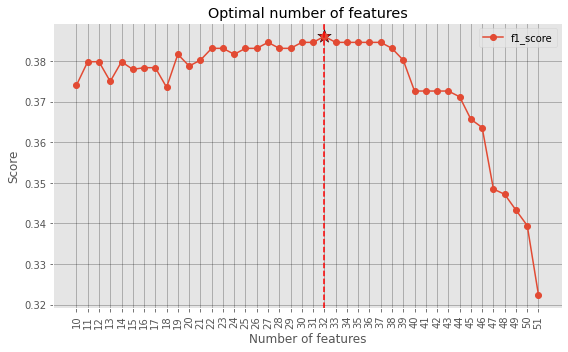

In [35]:
k_feat = [len(k) for k in selector.subsets_]
plt.figure(figsize=(8, 5))
plt.plot(k_feat, selector.scores_, marker='o', label='f1_score')
plt.scatter(k_feat[np.argmax(np.array(selector.scores_))], max(selector.scores_), marker='*', color='red', ec='black', s=200)
plt.axvline(k_feat[np.argmax(np.array(selector.scores_))], color='red', linestyle='--')
plt.title('Optimal number of features')
plt.ylabel('Score')
plt.xlabel('Number of features')
plt.xticks(k_feat, rotation=90)
plt.legend(loc='best')
plt.grid(color='black', alpha=0.3)
plt.tight_layout()
plt.show()

In [36]:
best_features = X_train.columns[list(selector.subsets_[np.argmax(selector.scores_)])]
best_features

Index(['dpd_5_cnt', 'dpd_15_cnt', 'dpd_30_cnt', 'close_loans_cnt', 'TraderKey',
       'payment_type_0', 'payment_type_1', 'payment_type_3', 'payment_type_4',
       'past_billings_cnt', 'score_1', 'score_2', 'gender',
       'federal_district_nm_region_1', 'federal_district_nm_region_5',
       'federal_district_nm_region_7', 'rep_loan_date_year',
       'rep_loan_date_month', 'first_loan_year', 'first_loan_day',
       'first_overdue_date_year', 'first_overdue_date_month',
       'first_overdue_date_day', 'loan_rep_loan_diff', 'loan_over_diff',
       'payment_sum_log', 'payment_type_1_log', 'payment_type_2_log',
       'age_18-29', 'age_30-40', 'trader_key_tar', 'pay_loan_2'],
      dtype='object')

**Learning curve plot**

Determines cross-validated training and test scores for different training set sizes. Helps to define appropriate train and test split and find out how many samples are the best for model with given parameters. Observing the plateau is a good sign - from this point the learning curve reached the best train size.

Also sometimes it is a good practice to use also validation set to calculate metrics and controll early stopping. And then make inference on test set. Some experts (like Andrew Ng) do not recommentd using early stopping in purpuse to complete the training phase (and regularize the model with other techniques: ridge, lasso; for tree models - learning rate, subsamples, colsamples, depth, num_estimators, etc.). Here validation set is not used because of small dataset size, but having it as hold-out set is strongly recommended.


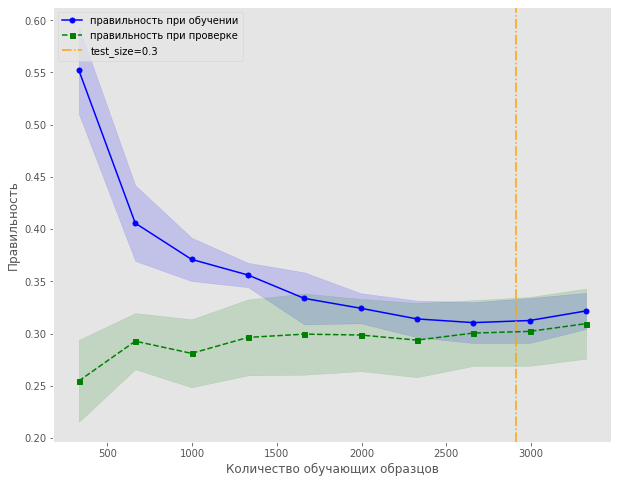

In [48]:
train_sizes, train_scores, test_scores = learning_curve(estimator=make_pipeline(RobustScaler(),
                                                                                LogisticRegression(class_weight='balanced',
                                                                                                   random_state=seed)), 
                                                        X=X, y=y, 
                                                        train_sizes=np.linspace(0.1, 1.0, 10), 
                                                        cv=5, scoring='f1', n_jobs=-1)
train_mean = np.mean(train_scores, axis=1)
train_std = np.std(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)
plt.figure(figsize=(10, 8))
plt.plot(train_sizes, train_mean, color='blue', marker='o', markersize=5, label='правильность при обучении')
plt.fill_between(train_sizes, train_mean + train_std, train_mean - train_std, alpha=0.15, color='blue')
plt.plot(train_sizes, test_mean, color='green', linestyle='--', marker='s', markersize=5, 
         label='правильность при проверке')
plt.fill_between(train_sizes, test_mean + test_std, test_mean - test_std, alpha=0.15, color='green')
plt.axvline(X.shape[0]*0.7, color='orange', linestyle='-.', label='test_size=0.3')
plt.grid()
plt.xlabel('Количество обучающих образцов')
plt.ylabel('Правильность')
plt.legend(loc='best')
plt.show()
# very lousy f1-score

Train_test_split is common function to split data into train/valid/test subsets (also it provides ability to stratify data by some feature or target). But in some cases it is necessary to split data with some  other criterion, e.g.: time-series split (to preserve the order of samples), split by user_id (when data contains behaviour dependency, e.g. fraud detecton tasks) or some other variable. For these purposes GroupKFold from sklearn can be applied, where specific groups have to be provided, that splits data so that each group will appear exactly once in the test set across all folds.

The best common practice is to use:
* hold-out split (train/valid/test), do not use test until the end to prevent data leakage;
* cross-validation.

Dataset sizes starting points:
* small 70:20:20;
* medium 60:20:20
* large has enough data for all splits.

In [49]:
# stat test on equality of split (kolmogorov-smirnov test may be better)
for column in X_train.columns:
    if X_train[column].nunique() > 2:
        tr_test_stats = stats.mannwhitneyu(X_train.loc[y_train == 1, column].sample(80, random_state=seed), 
                                           X_test.loc[y_test == 1, column].sample(80, random_state=seed))
        tr_test_stats2 = stats.mannwhitneyu(X_train.loc[y_train == 0, column].sample(80, random_state=seed), 
                                            X_test.loc[y_test == 0, column].sample(80, random_state=seed))
        print(column, ':', tr_test_stats[1], tr_test_stats2[1])
    else:
        n1, k1 = len(X_train), X_train[column].sum()
        n2, k2 = len(X_test), X_test[column].sum()
        z_score, pvalue = proportion.proportions_ztest(np.array([k1, k2]), np.array([n1, n2]))
        print(column, ':', pvalue)
# every p-value is greater than significance level of 5%
# (note: non-parametric test on continuous sampled means maybe not quite suitable for binary data)

dpd_5_cnt : 0.1825441618914193 0.5341999685681309
dpd_15_cnt : 0.33976428283283333 0.5726147307493175
dpd_30_cnt : 0.46956765460622363 0.7388311695250805
close_loans_cnt : 0.0002811691164056165 0.7830507785399079
TraderKey : 0.6329424506539012 0.15216039525979996
payment_type_0 : 1.0 0.32339758291457144
payment_type_1 : 0.10339869473300234 0.16240794349534693
payment_type_2 : 0.7908577155443833 0.11679215431022945
payment_type_3 : 0.21621406920247632 0.26934290179414133
payment_type_4 : 0.32339758291457144 1.0
past_billings_cnt : 0.04857870795947205 0.22762990830323648
score_1 : 0.19505374715273704 0.30255584750548903
score_2 : 0.8387284523799163 0.34251479682920116
age : 0.3227106018290814 0.3727373768207969
gender : 0.29105687003103475
score : 0.17590280873014252 0.19100808544258596
federal_district_nm_region_1 : 0.6578169576050124
federal_district_nm_region_2 : 0.7911344969246599
federal_district_nm_region_3 : 0.6086120310398996
federal_district_nm_region_4 : 0.34777382377242216
fed

More powerfull (as stat tests may often fail to apply $H_0$ on big samples and small samples):

* calculate PSI: compare bins on two samples
* use ML model (not very complex, e.g. GBM with low amount of trees and low depth) with concatenated train and test features and target train == 0, test == 1; use roc_auc_score as metric. The goal of such approach is to get metric close to 0.5 - random guessing, which means that train and test are grown from one distribution. If metric is far from 0.5 - inspect feature importancies: the most important features make the distribution shift in train/test.

**TSNE**

TSNE - is a tool to visualize high-dimensional data. It converts similarities between data points to joint probabilities and tries to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data.

In common it can be used to find out whether the data can be separable. But it cannot confirm whether the data is linearly separable as such transforms are non-linear.

In [50]:
tsne = make_pipeline(MinMaxScaler(), TSNE(n_components=3, 
                                          perplexity=30, 
                                          init='pca', 
                                          metric='cosine',
                                          n_jobs=-1)).fit_transform(X_train[best_features])

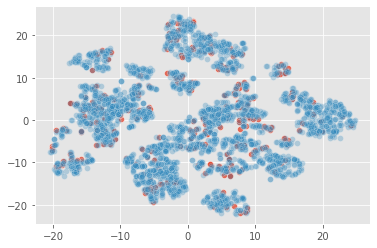

In [51]:
# 2 component 2d plot
red = y_train == 1
green = y_train == 0
sns.scatterplot(tsne[red, 0], tsne[red, 1], alpha=0.8)
sns.scatterplot(tsne[green, 0], tsne[green, 1], alpha=0.3)
plt.show()
# classes do not seem to be well separated

In [52]:
import plotly.graph_objects as go

In [53]:
fig = go.Figure(data=[go.Scatter3d(
    x=tsne[:,0],
    y=tsne[:,1],
    z=tsne[:,2],
    mode='markers',
    marker=dict(
        size=12,
        color=y_train,                
        colorscale='GnBu',   
        opacity=0.8
    )
)])
fig.show()

In [74]:
# umap has lots of ways to use: outlier detection, clustering, dimensionality reduction, etc.
import umap

def return_fig(u):
    return go.Figure(data=[go.Scatter3d(
                     x=u[:,0],
                     y=u[:,1],
                     z=u[:,2],
                     mode='markers',
                     marker=dict(
                                 size=12,
                                 color=y_train,                
                                 colorscale='GnBu',   
                                 opacity=0.8
                            )
                        )])

def draw_umap(data, n_neighbors=15, min_dist=0.1, n_components=3, metric='euclidean', title=''):
    fit = umap.UMAP(
        n_neighbors=n_neighbors,
        min_dist=min_dist,
        n_components=n_components,
        metric=metric
    )
    u = fit.fit_transform(data);
    if n_components == 1:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], range(len(u)), c=data)
        plt.title(title, fontsize=18)
        plt.tight_layout()
    if n_components == 2:
        fig = plt.figure()
        ax = fig.add_subplot(111)
        ax.scatter(u[:,0], u[:,1], c=data)
        plt.title(title, fontsize=18)
        plt.tight_layout()
    if n_components == 3:
        fig = return_fig(u)
    fig.show()

In [75]:
draw_umap(MinMaxScaler().fit_transform(X_train))

**Numerical feature scaling**

When to scale - when using gradient descent for weights optimization: to assign weights to features correctly. Tree models do not need any scaling. Fit on train distribution, on test - only transform assuming the same distribution in unseen data.

Common scalers:
* StandardScaler, scales data in range [-1, 1], better to use when data is drawn from normal distribution or close to it - $X_{scaled}^{(i)} = \frac{X_i - X_{mean}}{X_{std}}$;
* MinMaxScaler, scales data in range [0, 1], better to use when data is not drawn from normal distribution, it makes data more normal - $X_{scaled}^{(i)} = \frac{X_i - X_{min}}{X_{max} - X_{min}}$;
* RobustScaler, better to use when data contains significant outliers - $X_{scaled}^{(i)} = \frac{Q_{50}^{(xi)}}{Q_{75}^{(xi)} - Q_{25}^{(xi)}}$, where Q - quartiles.

**Bias / Variance Tradeoff**

The goal is to find optimal proportion of bias (simple model underfits - cannot learn/extract some deep information from data) and variance (complex model overfits - perfectly learn train data, including noise and perform poorly on test data). 

$Total Error = Bias^2 + Variance + Irreducableerror$

Bias:

* use more data points for training;
* increase complexity of model;
* generate new features with non-linear relationships.

Variance:
* regularization;
* simplify model or data;
* reduce dimensionality when it is large;
* early stopping;
* feature selection (remove noisy and redundant);
* cross-validation to check model stability.

etc.

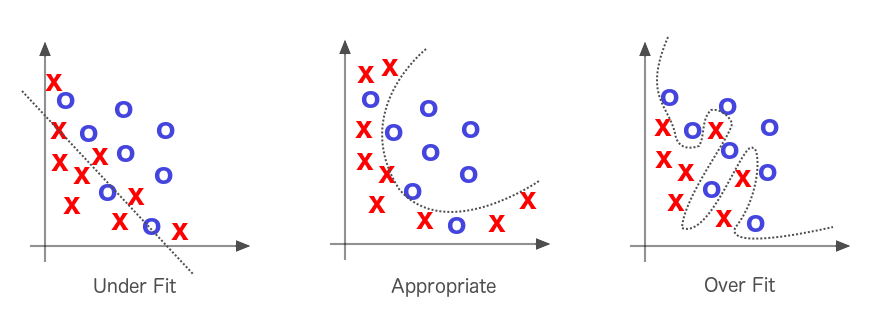

**LogisticRegression**

* uses iterative gradient descent weight optimization;
* minimizes logloss $L = -y\cdot log(p) - (1-y)\cdot log(1-p)$, where p = probability of positive class, y - true label;
* often a good choice for banking credit tasks.

**SVM**

* also uses gradient descent for weight optimization;
* maximizes the gap between positive and negative class subspaces, minimizes hinge loss $L = max(0, y\cdot <w^T, X>)$

**Random Forest (and more random analogue ExtraTreeClassifier)**

* Uses ensemble of trees to predict value (regression - mean, classification - most frequent). Builds trees simultoniously using bootstrap subsamples and random subset of features on every tree. Rarely overfits, computationally expensive (not applicable for large datasets > 100k samples), compensates bias by averaging predictions, limited by the complexity of base model. 

**Boosting model (CatBoost)**

* Trains base models sequentially, reduces previous tree model error by predicting error of previous tree. Every tree uses residual (gradient of loss function) to train on subsets of X. The prediction raw value is the sum of base predictions, reduced by learning rate (parameter needed to decrease the impact of every base model on the answer - in case of base model predicts anomalous value).
* catboost advantages: handling categorical features (encode by permuting and obtain statistics on the previous observations before current value multiple times), ordered boosting (perfect for small datasets; every next base model trains on samples, that were obtained by previous model, that was itself trained on previous permuted samples; eliminating prediction shift), symmetrictree (uses the same split rule on every tree level, thus the tree becomes symmetric - decision table), high speed and many others.

### LogisticRegression

In [76]:
X_train[best_features].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3325 entries, 231442 to 795505
Data columns (total 28 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   dpd_5_cnt                     3325 non-null   float32
 1   dpd_15_cnt                    3325 non-null   float32
 2   TraderKey                     3325 non-null   int8   
 3   payment_type_0                3325 non-null   int8   
 4   payment_type_4                3325 non-null   int8   
 5   past_billings_cnt             3325 non-null   float32
 6   age                           3325 non-null   float32
 7   gender                        3325 non-null   int8   
 8   score                         3325 non-null   float32
 9   federal_district_nm_region_2  3325 non-null   uint8  
 10  federal_district_nm_region_3  3325 non-null   uint8  
 11  federal_district_nm_region_4  3325 non-null   uint8  
 12  federal_district_nm_region_5  3325 non-null   uint8  
 

In [77]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
        
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        if not isinstance(X, pd.DataFrame):
            return X
        return X[self.columns]

In [78]:
numerical_columns = X_train[best_features].select_dtypes([np.float32, np.float64, np.int8, np.int16]).columns.tolist()
binary_columns = [col for col in X_train.columns if col not in numerical_columns]

union = make_union(make_pipeline(ColumnSelector(numerical_columns),
                                 MinMaxScaler(),),
                   make_pipeline(ColumnSelector(binary_columns))
                  )
pipe = make_pipe(union,
                 SMOTETomek(sampling_strategy=1, random_state=seed, n_jobs=-1),
                 # PolynomialFeatures(degree=2, interaction_only=True),
                 LogisticRegression(class_weight='balanced', C=100, random_state=seed, n_jobs=-1)
                ).fit(X_train, y_train)

train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)
train_probas = pipe.predict_proba(X_train)[:,1]
test_probas = pipe.predict_proba(X_test)[:,1]

report(y_train, train_pred, y_test, test_pred, train_probas, test_probas)
print(get_best_threshold(y_test, test_probas))
scores = cross_validation(pipe[-1], X_train, y_train)

Train
               precision    recall  f1-score   support

           0     0.9509    0.7192    0.8190      2991
           1     0.2098    0.6677    0.3193       334

    accuracy                         0.7140      3325
   macro avg     0.5804    0.6934    0.5691      3325
weighted avg     0.8765    0.7140    0.7688      3325

Test
               precision    recall  f1-score   support

           0     0.9318    0.7116    0.8070       749
           1     0.1692    0.5301    0.2566        83

    accuracy                         0.6935       832
   macro avg     0.5505    0.6209    0.5318       832
weighted avg     0.8557    0.6935    0.7521       832

Train ROC_AUC: 0.753, Test ROC_AUC: 0.671
Train GINI: 0.506, Test GINI: 0.343
(0.6358963754827651, 0.28703703703703703)
Меры правильности перекрекстной оценки: [0.31 0.31 0.34 0.3  0.3 ]
Точность перекретсной оценки: 0.311 +/- 0.013


### SVM

In [79]:
pipe = make_pipe(union,
                 # SMOTETomek(sampling_strategy=0.3, random_state=seed, n_jobs=-1),
                 SVC(kernel='linear',
                     degree=3,
                     gamma='scale',
                     probability=True,
                     class_weight='balanced', 
                     random_state=seed
                    )
                ).fit(X_train, y_train)

train_pred = pipe.predict(X_train)
test_pred = pipe.predict(X_test)
train_probas = pipe.predict_proba(X_train)[:,1]
test_probas = pipe.predict_proba(X_test)[:,1]

report(y_train, train_pred, y_test, test_pred, train_probas, test_probas)
print(get_best_threshold(y_test, test_probas))
scores = cross_validation(pipe[-1], X_train, y_train)
# model overfitted

Train
               precision    recall  f1-score   support

           0     0.9623    0.6830    0.7990      2991
           1     0.2113    0.7605    0.3307       334

    accuracy                         0.6908      3325
   macro avg     0.5868    0.7218    0.5649      3325
weighted avg     0.8869    0.6908    0.7519      3325

Test
               precision    recall  f1-score   support

           0     0.9467    0.6876    0.7966       749
           1     0.1875    0.6506    0.2911        83

    accuracy                         0.6839       832
   macro avg     0.5671    0.6691    0.5439       832
weighted avg     0.8710    0.6839    0.7462       832

Train ROC_AUC: 0.791, Test ROC_AUC: 0.735
Train GINI: 0.582, Test GINI: 0.471
(0.7276912951502997, nan)
Меры правильности перекрекстной оценки: [0.32 0.27 0.28 0.25 0.26]
Точность перекретсной оценки: 0.278 +/- 0.023


### Random Forest / ExtraTree

In [104]:
%%time
# GridsearchCV for forest
param_grid = {
              'n_estimators': [50, 100, 200, 500, 1000],
              'max_depth': [None, 3, 5, 8],
              'ccp_alpha': [0, 1, 3],
              'max_samples': [None, 0.8, 0.5],
              'min_samples_leaf': [1, 10, 50],
              'min_samples_split': [2, 10, 50]
}

logreg = make_pipeline(MinMaxScaler(),
                       LogisticRegression(penalty='l1', solver='saga', C=0.5, 
                                          class_weight='balanced', random_state=42, n_jobs=-1)).fit(X_train, y_train)

CPU times: total: 156 ms
Wall time: 161 ms


In [106]:
rf = RandomForestClassifier(random_state=seed, 
                            n_jobs=-1, 
                            class_weight='balanced', 
                            bootstrap=True, 
                            max_features='sqrt',
                            criterion='gini',
                            )

gs = make_pipeline(SelectFromModel(estimator=logreg[-1], prefit=False, threshold=1e-5),
                   GridSearchCV(estimator=rf, param_grid=param_grid, scoring='f1', cv=3, n_jobs=-1)).fit(X_train, y_train)

In [108]:
pprint(gs[-1].best_params_)
pprint(gs[-1].best_score_)

{'ccp_alpha': 0,
 'max_depth': None,
 'max_samples': 0.5,
 'min_samples_leaf': 10,
 'min_samples_split': 2,
 'n_estimators': 500}
0.40235858773122396


In [109]:
params = {'ccp_alpha': 0,
          'max_depth': None,
          'max_samples': 0.5,
          'min_samples_leaf': 10,
          'min_samples_split': 2,
          'n_estimators': 500}

rf = ExtraTreesClassifier(random_state=seed, 
                            n_jobs=-1, 
                            class_weight='balanced', 
                            bootstrap=True, 
                            max_features='sqrt',
                            criterion='gini', **params
                                                      )

forest = make_pipeline(SelectFromModel(estimator=logreg[-1], prefit=False, threshold=1e-5),
                       rf).fit(X_train, y_train)

In [111]:
train_pred = forest.predict(X_train)
test_pred = forest.predict(X_test)
train_probas = forest.predict_proba(X_train)[:,1]
test_probas = forest.predict_proba(X_test)[:,1]

report(y_train, train_pred, y_test, test_pred, train_probas, test_probas)
print(get_best_threshold(y_test, test_probas))
scores = cross_validation(forest[-1], X_train, y_train)

Train
               precision    recall  f1-score   support

           0     0.9657    0.8378    0.8972      2991
           1     0.3356    0.7335    0.4605       334

    accuracy                         0.8274      3325
   macro avg     0.6507    0.7857    0.6789      3325
weighted avg     0.9024    0.8274    0.8534      3325

Test
               precision    recall  f1-score   support

           0     0.9457    0.8131    0.8744       749
           1     0.2553    0.5783    0.3542        83

    accuracy                         0.7897       832
   macro avg     0.6005    0.6957    0.6143       832
weighted avg     0.8768    0.7897    0.8225       832

Train ROC_AUC: 0.878, Test ROC_AUC: 0.779
Train GINI: 0.757, Test GINI: 0.557
(0.5421310544194087, 0.39999999999999997)
Меры правильности перекрекстной оценки: [0.34 0.35 0.36 0.37 0.37]
Точность перекретсной оценки: 0.357 +/- 0.010


### CatBoost

##### Before start

XGBoost:
* slower but often most accurate;
* have objectness: $obj(\theta) = L(\theta) + \Omega(\theta)$;
* regularization: $\Omega(f) = \gamma T + \frac{1}{2}\lambda\sum_{j=1}^{T}w_j^2$, where $\gamma$ specifies the minimum loss reduction required to make a split, $\lambda$ is actually reg_lambda (more classic reg parameter), T - number of leaves (trying ti reduce number of leaves), $w_j$ - vector of predictions in leaf $j$;
* sorts feature values and consider split only on threshold after which the class label changes (for classification task).

LGBM
* based on constructing histograms (bins) in continuous features ($bins << N_{samples}$) (as well as catboost);
* uses leaf-wise tree architecture (despite of level-wise): decides whether to build new leaf with respect to loss value;
* categorical features calculated as $\frac{\sum_j{grad_j}} {\sum_j{hessian}}$: first and second derivatives;
* GOSS (Gradient Based One Side Sampling) - use samples with large gradients with $\alpha$ proportion. Sample small gradienrts with $(1 - \alpha) / \beta$. Also may use weights to preserve the dataset distribution (so here reducing number of rows in dataset);
* EFB (Exclusive Feature Bundling): creates bundle features from given in dataset by calculating number of unique features combinations. Reduces columns to train with. 

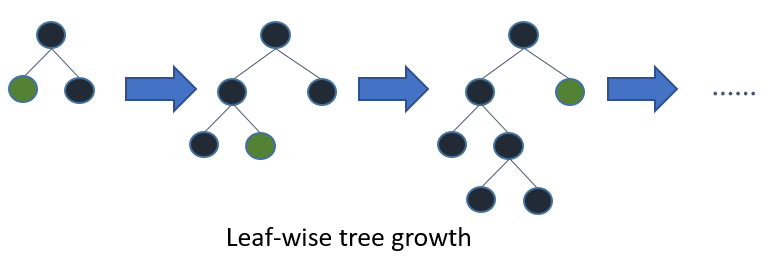

CatBoost:
* Uses SymmetricTree structure (decision tables), which is good for data paralleling;
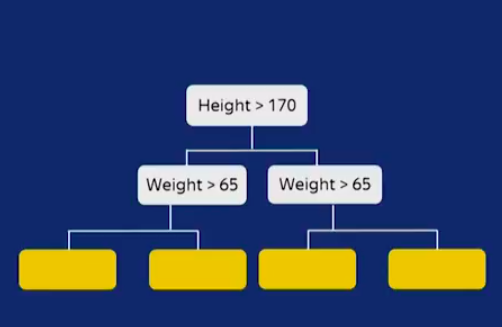
* Ordered boosting, when every new tree constructs using residuals, predicted by other virtual trees, that were not trained with these samples. Creates $log_2{N_{samples}}$ trees. To prevent prediction shift random permutations additionally applied with $bagging-temperature$ parameter;
* Uses ordered target encoding: after permutation of dataset calculate target mean on i-th sample using only previous i-1 samples, repeat permutation multiple times: $x_k = \frac{\sum{cats (e.g. 1,1,0)} + a \cdot p}{\sum{(e.g. 1,1,1)}+a}$, where a is hyperparameter and p is total target mean;
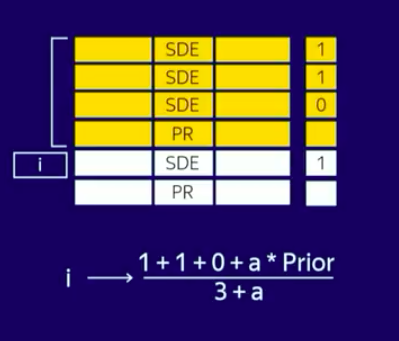
* Uses multiple combinations of categorical features with max_ctr_complexity parameter.

Usefull notes: 
* if boosting model has big tree depth with no overfitting, than it is better to construct some new features (interactions) so model would not need to find these non-linear relationships by increasing its complexity. This speeds up the process;
* important regularization parameters: num_leaves (constraint on number of leaves, thus the tree depth), min_child_weight - the tree stops splitting if sum of weights of leaf instances in child nodes (leaves) goes beyond this given threshold (0..1000);
* lifehack: when optimal number of trees is found - multiply n_estimators by $\alpha$ and divide learning rate by same $\alpha$.

In [429]:
class Preprocessor(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, X):
        df = X.copy()
        df.set_index('loanKey', inplace=True)

        df.drop('payment_type_5', axis=1, inplace=True)

        df['rep_loan_date'] = pd.to_datetime(df['rep_loan_date'])
        df['first_loan'] = pd.to_datetime(df['first_loan'])
        df['first_overdue_date'].fillna(0, inplace=True)  
        df['first_overdue_date'] = pd.to_datetime(df['first_overdue_date'])

        df['gender'] = df['gender'].map({True: 'male', False: 'female'})

        df['score'] = 0
        df.loc[~df['score_1'].isna(), 'score'] = df.loc[~df['score_1'].isna(), 'score_1']
        df.loc[~df['score_2'].isna(), 'score'] = df.loc[~df['score_2'].isna(), 'score_2']

        df['federal_district_nm'].fillna(df['federal_district_nm'].mode()[0], inplace=True)
        df.fillna(0, inplace=True)

        df['rep_loan_date_year'] = df['rep_loan_date'].dt.year
        df['rep_loan_date_month'] = df['rep_loan_date'].dt.month
        df['rep_loan_date_day'] = df['rep_loan_date'].dt.day

        df['first_loan_year'] = df['first_loan'].dt.year
        df['first_loan_month'] = df['first_loan'].dt.month
        df['first_loan_day'] = df['first_loan'].dt.day

        df['first_overdue_date_year'] = 0  
        df['first_overdue_date_month'] = 0
        df['first_overdue_date_day'] = 0
        condition = (df['first_overdue_date'] != '1970-01-01')
        df.loc[condition, 'first_overdue_date_year'] = df.loc[condition, 'first_overdue_date'].dt.year
        df.loc[condition, 'first_overdue_date_month'] = df.loc[condition, 'first_overdue_date'].dt.month
        df.loc[condition, 'first_overdue_date_day'] = df.loc[condition, 'first_overdue_date'].dt.day

        df['loan_rep_loan_diff'] = (df['rep_loan_date'] - df['first_loan']).dt.days
        df['loan_over_diff'] = (df['first_overdue_date'] - df['first_loan']).dt.days
        df.loc[df['loan_over_diff'] < 0, 'loan_over_diff'] = 0
    
        df['rep_over_diff'] = (df['rep_loan_date'] - df['first_overdue_date']).dt.days
        df.loc[df['rep_over_diff'] > 1000, 'rep_over_diff'] = 0

        df['payment_sum'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 
                                'payment_type_3', 'payment_type_4']].sum(axis=1)
        df['payment_sum_log'] = np.log(df['payment_sum']+1)

        df['payment_mean'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 
                                 'payment_type_3', 'payment_type_4']].mean(axis=1)
        df['payment_std'] = df[['payment_type_0', 'payment_type_1', 'payment_type_2', 
                                'payment_type_3', 'payment_type_4']].std(axis=1)

        df['payment_type_0_log'] = np.log(df['payment_type_0']+1)
        df['payment_type_1_log'] = np.log(df['payment_type_1']+1)
        df['payment_type_2_log'] = np.log(df['payment_type_2']+1)

        df.drop(['rep_loan_date', 'first_loan', 'first_overdue_date'], axis=1, inplace=True)

        df['age_bin'] = pd.cut(df['age'], [16,30,40,51,64,90], labels=['18-29', '30-40', '40-51', '52-63', '64+'])

        df['close_bill_diff'] = df['close_loans_cnt'] - df['past_billings_cnt']
        df['score_2_age_ratio'] = df['score_2'] / df['age']

        df['TraderKey'] = df['TraderKey'].astype('category')
        
        # these features are "days past due" values, numerical counts, but categories performs better here
        cat_dict = {i: str(i) for i in range(50)}
        df['dpd_5_cnt'] = df['dpd_5_cnt'].astype('int').map(cat_dict)
        df['dpd_15_cnt'] = df['dpd_15_cnt'].astype('int').map(cat_dict)
        df['dpd_30_cnt'] = df['dpd_30_cnt'].astype('int').map(cat_dict)
        
        # df.drop(['score_1', 'score_2'], axis=1, inplace=True)  # dropped for second approach
        
        # making payment types as category do not improve model performance

        df = reduce_memory_df(df)
        
        return df

In [430]:
df = pd.read_csv('revo_ds_test_task.csv')
df = Preprocessor().fit_transform(df)

Memory usage of dataframe is 1.25 MB
Memory usage after optimization is: 0.38 MB
Decreased by 69.3%


In [431]:
X, y = df.drop(TARGET, axis=1), df[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=seed)

cat_features = X_train.select_dtypes('category').columns.tolist()

In [432]:
# check for train/test equality
X_inspect = pd.concat([X_train, X_test], axis=0)
y_inspect = np.hstack((np.ones(X_train.shape[0]), np.zeros(X_test.shape[0])))

model = CatBoostClassifier(depth=3, 
                           iterations=50, 
                           silent=True, 
                           allow_writing_files=False, 
                           cat_features=cat_features,
                           auto_class_weights='Balanced',
                           random_seed=seed)
model.fit(X_inspect, y_inspect)

cv = cross_val_score(
    estimator=model,
    X=X_inspect, y=y_inspect,
    scoring="roc_auc",
    cv=KFold(n_splits=3, shuffle=True, random_state=27)
)

print(f"CV-score: {round(np.mean(cv), 4)}")

CV-score: 0.5002


In case when train and test subset contain features that are not equaly distributed it is good choice to perform *adversarial validation*, the goal here is similar to what was done above: 
* concatenate xtrain and xtest subsets;
* label train samples with zeros and test samples with ones;
* train not complex model to classify concatenated samples using roc_auc metric;
* choose from xtrain part samples, sorted by predicted probability of being positive sample (the most similar to xtest);
* use these samples as validation set during feature selection, hyperparameters tunning etc.

In [433]:
train_pool = Pool(X_train, y_train, cat_features=cat_features)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

In [488]:
total_params = {
                'iterations': 100,
                'silent': True,
                'one_hot_max_size': 2,
                'eval_metric': 'F1',
                'allow_writing_files': False,
                'random_seed': seed,
                'auto_class_weights': 'SqrtBalanced',    
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss',
                'boosting_type': 'Ordered',
                'score_function': 'Cosine',
                'bagging_temperature': 1,
                'l2_leaf_reg': 3,
}

In [493]:
cat_cols = X_train.select_dtypes(include='category').columns.tolist()
scores, importance = calculate_permutation_importance(estimator=CatBoostClassifier(cat_features=cat_cols, 
                                                                                   **total_params).fit(X_train, y_train), 
                                                      metric=f1_score,
                                                      x_valid=X_train,
                                                      y_valid=y_train)  # use with valid 
importance

  0%|          | 0/39 [00:00<?, ?it/s]

score                       0.203311
score_1                     0.114075
loan_rep_loan_diff          0.054306
close_loans_cnt             0.034091
rep_over_diff               0.016359
payment_sum_log             0.013215
close_bill_diff             0.012220
first_overdue_date_month    0.012043
payment_type_3              0.011389
payment_std                 0.008112
payment_type_1              0.006645
first_overdue_date_year     0.005095
loan_over_diff              0.004865
first_overdue_date_day      0.003500
payment_type_1_log          0.002859
payment_sum                 0.002429
rep_loan_date_day           0.002429
rep_loan_date_year          0.001760
payment_mean                0.000835
gender                      0.000670
dpd_15_cnt                  0.000156
payment_type_0_log          0.000000
payment_type_2_log          0.000000
age_bin                     0.000000
dpd_5_cnt                   0.000000
first_loan_day              0.000000
first_loan_year             0.000000
r

In [435]:
# as boruta creates shadow features cat_shadow_features are also created, so CatBoost raises error as it does not expect new
# categorical features during training. So next: extract usefull features from select_features method

def select_features(algorithm: EFeaturesSelectionAlgorithm, steps: int = 1):
    print('Algorithm:', algorithm)
    model = CatBoostClassifier(**total_params)
    summary = model.select_features(
                                    train_pool,
                                    eval_set=test_pool,  # this leads to data leakage here but assume this in order to visual.
                                    features_for_select=list(range(X_train.shape[1])),
                                    num_features_to_select=12,
                                    steps=steps,
                                    algorithm=algorithm,
                                    shap_calc_type=EShapCalcType.Exact,
                                    train_final_model=True,
                                    logging_level='Silent',
                                    plot=True
    ) 
    print('Eliminated features:', summary['eliminated_features_names'])
    return summary

feature_set = select_features(algorithm=EFeaturesSelectionAlgorithm.RecursiveByShapValues, steps=27)

Algorithm: EFeaturesSelectionAlgorithm.RecursiveByShapValues


MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

Eliminated features: ['rep_loan_date_month', 'close_loans_cnt', 'payment_type_1', 'payment_type_1_log', 'rep_loan_date_day', 'dpd_5_cnt', 'close_bill_diff', 'dpd_15_cnt', 'loan_over_diff', 'score_2_age_ratio', 'first_loan_year', 'payment_type_2', 'payment_sum_log', 'first_loan_month', 'payment_type_4', 'payment_mean', 'dpd_30_cnt', 'score_2', 'payment_type_0_log', 'payment_sum', 'federal_district_nm', 'payment_type_2_log', 'rep_loan_date_year', 'first_loan_day', 'past_billings_cnt', 'payment_type_3', 'age_bin']


In [436]:
losses = feature_set['loss_graph'].get('loss_values')
names = feature_set['eliminated_features_names']

eliminated_features = [names[i] for i in range(len(names) - 1) if losses[i+1] - losses[i] < 0]

In [437]:
cat_features = [feat for feat in cat_features if feat not in eliminated_features]
train_pool = Pool(X_train.drop(eliminated_features, axis=1), y_train, cat_features=cat_features)

**Hyperparameters tunning**

In [483]:
base_params = {
                'silent': True,
                'iterations': 30,
                'early_stopping_rounds': 5,
                'one_hot_max_size': 2,
                'eval_metric': 'F1',
                'allow_writing_files': False,
                'random_seed': seed,
                'auto_class_weights': 'SqrtBalanced',    
                'grow_policy': 'SymmetricTree',
                'objective': 'Logloss',
                'boosting_type': 'Ordered',
                'score_function': 'Cosine',
                'bootstrap_type': 'MVS'
}
# early stopping rounds are not applied here, regularization by other model parameters

In [439]:
train, val, tr_y, val_y = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=seed)

In [485]:
tr_pool = Pool(train.drop(eliminated_features, axis=1), tr_y, cat_features=cat_features)
val_pool = Pool(val.drop(eliminated_features, axis=1), val_y, cat_features=cat_features)

def objective(trial):
    param_trials = {
                    'depth': trial.suggest_int('depth', 3, 8),
                    'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.5),
                    'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 3., 50.),
                    'bagging_temperature': trial.suggest_float('bagging_temperature', 1., 10.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'colsample_bylevel': trial.suggest_float('colsample_bylevel', 0.3, 1.),
                    'max_ctr_complexity': trial.suggest_int('max_ctr_complexity', 2, 6)
                    }
    
    param_trials.update(base_params)
    
    # basic approach
    # opt_model = CatBoostClassifier(**param_trials)
    # opt_model.fit(tr_pool, eval_set=val_pool)
    
    # y_pred = catboost.CatBoost.predict(opt_model, val_pool, prediction_type='Class')
    # score = f1_score(val_y, y_pred)
    fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=seed)
    
    scores = cross_val_score(
        estimator=CatBoostClassifier(cat_features=cat_features, **param_trials),
        X=X.drop(eliminated_features, axis=1), 
        y=y, 
        cv=fold, 
        scoring="f1",
        n_jobs=-1
    )
    score = np.mean(scores)
    
    return score

In [494]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=seed), direction="maximize")
study.optimize(objective, n_trials=1000, timeout=3000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
pprint(trial.params)

Number of completed trials: 1000
Best trial
Best score: 0.39954506368811493
Best params
{'bagging_temperature': 8.680153530502823,
 'colsample_bylevel': 0.8393465590576243,
 'depth': 3,
 'l2_leaf_reg': 31.39733907456943,
 'learning_rate': 0.2933455544073753,
 'max_ctr_complexity': 6,
 'subsample': 0.8637152380992008}


In [523]:
total_params = {
                'silent': True,  # whether to output training results
                'one_hot_max_size': 2,  # maximum size of one-hot categories in feature, >2 = catboost target encoding
                'iterations': 2000,  # number of trees to construct (despite some opinions for never use early stopping)
                'early_stopping_rounds': 50,  # as if eval metric is used: take big amount of trees and cut
                'eval_metric': 'F1',  # metric to measure model performance
                'allow_writing_files': False,  # whether to write logs of training
                'random_seed': seed,  # for reproducability
                'auto_class_weights': 'SqrtBalanced',  # balance imbalanced target
                'grow_policy': 'SymmetricTree',  # build tree with decision table: same criterion on every tree level
                'objective': 'Logloss',  # classification loss: -y*log(p) - (1-y)*log(1-p)
                'boosting_type': 'Ordered',  # build every tree on 'new' train data to eliminate predeiction shift
                'score_function': 'Cosine',  # to choose split and tree, score F(delta, G)
                'bootstrap_type': 'MVS',  # lightgbm goss improvement: sampling good samples
                'bagging_temperature': 8.680153530502823,  # agression of bootstraping
                'colsample_bylevel': 0.8393465590576243,  # randomly choose this propotion of features on every tree level
                'depth': 3,  # depth of every base estimator (tree)
                'l2_leaf_reg': 31.39733907456943,  # regularization term in each leaf (in denominator)
                'learning_rate': 0.33196388260197407,  # the size of contribution of every tree gradient prediction in result
                'max_ctr_complexity': 6,  # maximum number of cat features to combine
                'subsample': 0.8637152380992008,  # the size of data randomly chosen for every tree
                'approx_on_full_history': False,  # when False calculate residuals for every obs. using different base models
                'fold_len_multiplier': 2,  # -//- default 2, both for small datasets
                'max_bin': 254,  # maximum number of bins to merge features values (to speed up training)
}  # has_time parameter for partial fit afterwards

In [496]:
%%time
# choose number of trees by cross-validation and ttest_rel (if not using eval_set for early_stopping)
scores_m1, scores_m2 = np.array([]), np.array([])
m1_params = total_params.copy()
m2_params = total_params.copy()
m1_params['iterations'] = 50
m1_params['early_stopping_rounds'] = None
m2_params['iterations'] = 1000  # catboost default
m2_params['early_stopping_rounds'] = None

for i in tqdm(range(10)):
    fold = KFold(n_splits=5, shuffle=True, random_state=i)
    cv_m1 = cross_val_score(
        estimator=CatBoostClassifier(cat_features=cat_features, **m1_params),
        X=X.drop(eliminated_features, axis=1), y=y, cv=fold, scoring="f1",
        n_jobs=-1
    )
    cv_m2 = cross_val_score(
        estimator=CatBoostClassifier(cat_features=cat_features, **m2_params),
        X=X.drop(eliminated_features, axis=1), y=y, cv=fold, scoring="f1",
        n_jobs=-1
    )

    scores_m1 = np.append(scores_m1, cv_m1)
    scores_m2 = np.append(scores_m2, cv_m2)

  0%|          | 0/10 [00:00<?, ?it/s]

CPU times: total: 234 ms
Wall time: 4min 49s


$ T(X_1^n,X_2^n) = \frac{E(X_1)-E(X_2)}{S/\sqrt{n}} $

* $X_1^n$, $X_2^n$ – lists of test metrics for m1 and m2 models;
* $S$ – variance of pairwise differences;
* $n$ – number of folds.

In [497]:
stats.ttest_rel(scores_m1, scores_m2)  
# p-value << 0.05 which means models are different
# model with 50 trees are statistically better

Ttest_relResult(statistic=6.3615250189134995, pvalue=6.470617116085409e-08)

  0%|          | 0/6 [00:00<?, ?it/s]

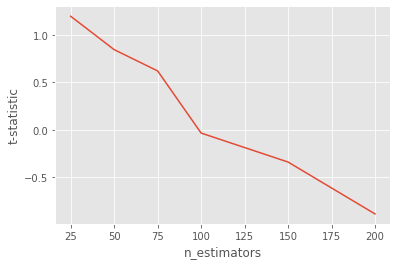

25
CPU times: total: 641 ms
Wall time: 2min 38s


In [498]:
%%time
# select number of trees using statistical methods

t_stats, n_trees = [], []

for j in tqdm((25, 50, 75, 100, 150, 200)):  # 1
    current_score = np.array([])
    for i in range(10):
        fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=i)
        m_params = m1_params.copy()
        m_params['iterations'] = j
        scores = cross_val_score(
            estimator=CatBoostClassifier(cat_features=cat_features, **m_params),
            X=X.drop(eliminated_features, axis=1),
            y=y, 
            scoring="f1",
            cv=fold,
            n_jobs=-1
        )
        current_score = np.append(current_score, scores)

    t_stat, p_value = stats.ttest_rel(current_score, scores_m1)  # scores_m1 - base_score
    t_stats.append(t_stat)  
    n_trees.append(j)

plt.plot(n_trees, t_stats)
plt.xlabel('n_estimators')
plt.ylabel('t-statistic')
plt.show()
print(n_trees[np.argmax(t_stats)])

In [524]:
alpha = 2
total_params['iterations'] = 10
total_params['early_stopping_rounds'] = 5

cat = CatBoostClassifier(**total_params).fit(tr_pool, eval_set=val_pool)

train_preds = catboost.CatBoost.predict(cat, tr_pool, prediction_type='Class')
test_preds = catboost.CatBoost.predict(cat, X_test.drop(eliminated_features, axis=1), prediction_type='Class')
train_probas = catboost.CatBoost.predict(cat, tr_pool, prediction_type='Probability')[:, 1]
test_probas = catboost.CatBoost.predict(cat, X_test.drop(eliminated_features, axis=1), prediction_type='Probability')[:, 1]

report(tr_y, train_preds, y_test, test_preds, train_probas, test_probas)
print(*get_best_threshold(y_test, test_probas))
# actually the results are quite disappointing

Train
               precision    recall  f1-score   support

           0     0.9343    0.9298    0.9320      2691
           1     0.3981    0.4153    0.4065       301

    accuracy                         0.8780      2992
   macro avg     0.6662    0.6725    0.6693      2992
weighted avg     0.8803    0.8780    0.8791      2992

Test
               precision    recall  f1-score   support

           0     0.9236    0.9199    0.9217       749
           1     0.3023    0.3133    0.3077        83

    accuracy                         0.8594       832
   macro avg     0.6130    0.6166    0.6147       832
weighted avg     0.8616    0.8594    0.8605       832

Train ROC_AUC: 0.805, Test ROC_AUC: 0.772
Train GINI: 0.610, Test GINI: 0.545
0.3709957954186325 0.3781512605042016


### Cross validation

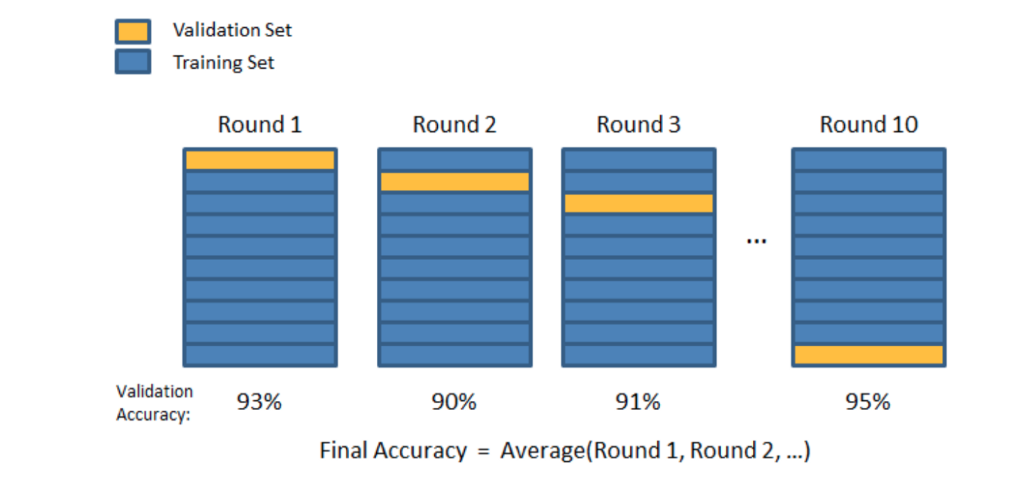

In [503]:
training_columns = [i for i, col in enumerate(X_train.columns) if col not in eliminated_features]

In [504]:
%%time

skf = StratifiedKFold(n_splits=5)
scores = []
cross_params = total_params.copy()
cross_params['iterations'] = 25
cross_params['early_stopping_rounds'] = None
models = []

for i, (train_index, valid_index) in enumerate(skf.split(X, y), 1):
    X_train_, X_test_ = X.iloc[train_index, training_columns], X.iloc[valid_index, training_columns]
    y_train_, y_test_ = y.iloc[train_index], y.iloc[valid_index]
    
    train_pool_ = Pool(X_train_, y_train_, cat_features=cat_features)
    test_pool_ = Pool(X_test_, y_test_, cat_features=cat_features)
    
    cat_ = CatBoostClassifier(**cross_params).fit(train_pool_)
    
    train_labels = catboost.CatBoost.predict(cat_, train_pool_, prediction_type='Class')
    labels = catboost.CatBoost.predict(cat_, test_pool_, prediction_type='Class')
    score = f1_score(y_test_, labels)
    print(f'{i}-fold score = {score:.4f}')
    
    scores.append(score)
    models.append(cat_)
    
print(f'Точность перекретсной оценки: {np.mean(scores):.4f} +/- {np.std(scores):.4f}')
# the model is overfitted as f1-score varies significantly on every split
# here also we may compute average using cross-validation estimators as ensemble! In many cases thos improves model accuracy.

1-fold score = 0.3077
2-fold score = 0.3418
3-fold score = 0.3867
4-fold score = 0.3830
5-fold score = 0.4556
Точность перекретсной оценки: 0.3749 +/- 0.0496
CPU times: total: 5.8 s
Wall time: 1.98 s


In [505]:
cv_data = catboost.cv(
    Pool(pd.concat([X_train.drop(eliminated_features, axis=1), 
                    X_test.drop(eliminated_features, axis=1)]), 
         pd.concat([y_train, y_test]), cat_features=cat_features),
    cross_params,
    stratified=True,
    plot=False,
    seed=seed
)

Training on fold [0/3]

bestTest = 0.5050501258
bestIteration = 3

Training on fold [1/3]

bestTest = 0.511253307
bestIteration = 0

Training on fold [2/3]

bestTest = 0.4991426013
bestIteration = 21



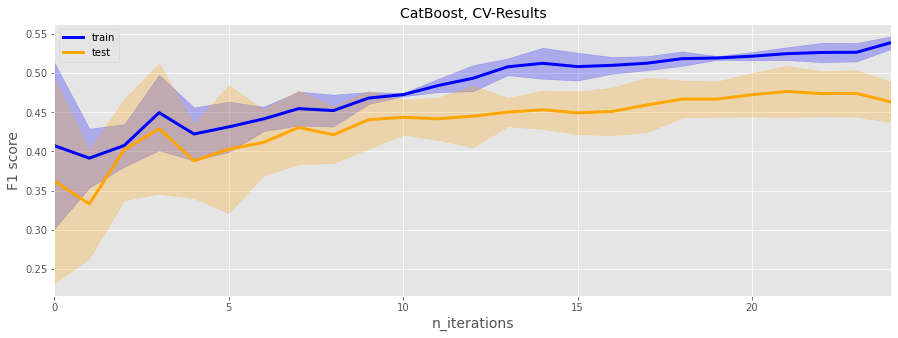

In [506]:
fig = plt.figure(figsize=(15, 5))
plt.plot(cv_data["train-F1-mean"], color="blue", linewidth=3, label="train")
plt.plot(cv_data["test-F1-mean"], color="orange", linewidth=3, label="test")
plt.fill_between(
    x=cv_data.index,
    y1=cv_data["train-F1-mean"] - cv_data["train-F1-std"],
    y2=cv_data["train-F1-mean"] + cv_data["train-F1-std"],
    alpha=0.25, color="blue"
)
plt.fill_between(
    x=cv_data.index,
    y1=cv_data["test-F1-mean"] - cv_data["test-F1-std"],
    y2=cv_data["test-F1-mean"] + cv_data["test-F1-std"],
    alpha=0.25, color="orange"
)
plt.title("CatBoost, CV-Results", size=14)
plt.xlabel("n_iterations", size=14)
plt.xlim(0, cv_data.index.max())
plt.ylabel("F1 score", size=14)
plt.legend(loc="best")
plt.show()
# model strongly overfitted

In [507]:
cat_ = models[-1]  # select best model, but keep in mind that due to high variance in model estimations, there could be 
# less "optimistic" results on new data

train_preds = catboost.CatBoost.predict(cat_, train_pool_, prediction_type='Class')
test_preds = catboost.CatBoost.predict(cat_, test_pool_, prediction_type='Class')
train_probas = catboost.CatBoost.predict(cat_, train_pool_, prediction_type='Probability')[:, 1]
test_probas = catboost.CatBoost.predict(cat_, test_pool_, prediction_type='Probability')[:, 1]

report(y_train_, train_preds, y_test_, test_preds, train_probas, test_probas)
print(*get_best_threshold(y_test_, test_probas))
# got low f1, also it is necessary to evaluate model with business metrics to decide if it has any perspective to be used
# it is necessary to take into account that the dataset is very small and starting features do not contain such common ones
# that is often used in such tasks, e.g. income, payments_amount, credit limit, credit account size, etc.

Train
               precision    recall  f1-score   support

           0     0.9328    0.9238    0.9283      2992
           1     0.3719    0.4042    0.3874       334

    accuracy                         0.8716      3326
   macro avg     0.6524    0.6640    0.6578      3326
weighted avg     0.8765    0.8716    0.8740      3326

Test
               precision    recall  f1-score   support

           0     0.9428    0.9251    0.9339       748
           1     0.4227    0.4940    0.4556        83

    accuracy                         0.8821       831
   macro avg     0.6827    0.7096    0.6947       831
weighted avg     0.8908    0.8821    0.8861       831

Train ROC_AUC: 0.820, Test ROC_AUC: 0.816
Train GINI: 0.641, Test GINI: 0.631
0.43147122268861837 0.4666666666666667


##### Calculate confidence interval for f1-score

In [697]:
scores = create_bootstrap_metrics(y_test_, catboost.CatBoost.predict(cat_, test_pool_, prediction_type='Class'), f1_score)

calculate_confidence_interval(scores)
# it is a huge interval which depicts model overfitting, but obtained from model performance metrics lies in this interval with
# probability of 95% (only for last estimator)

(0.35372148859543817, 0.5389021145497829)

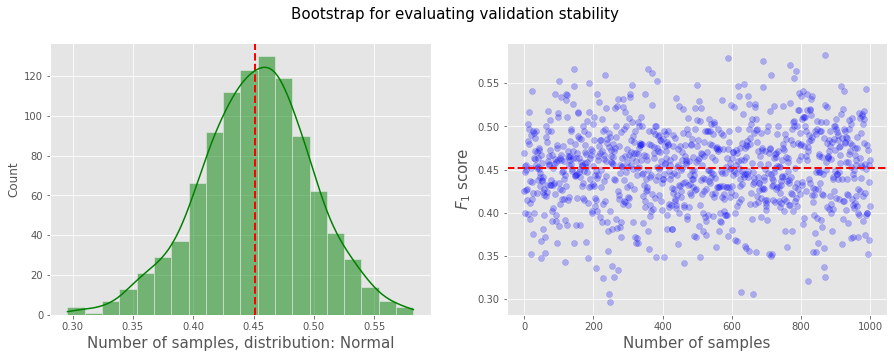

In [698]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$F_1$ score", size=15)
distribution = "Normal" if stats.shapiro(scores)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(scores), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(scores), lw=2, ls='--', c='red')
sns.histplot(scores, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()
# scatter plot is very sparsed, test distribution looks like close to gaussian
# cv is built correctly if metric, calculated with ground truth labels lies in CI

In [510]:
iso = IsolationForest(n_estimators=50, 
                      contamination=0.001,
                      random_state=seed, 
                      bootstrap=True,
                      n_jobs=-1).fit(X.drop(eliminated_features, axis=1).select_dtypes(include="number"))

In [511]:
model = CatBoostClassifier(cat_features=cat_features, **total_params)

estimators, oof_score, fold_train_scores, fold_valid_scores, oof_predictions = make_modify_cross_validation(
    X.drop(eliminated_features, axis=1), 
    y, 
    model, 
    metric=f1_score, 
    cv_strategy=StratifiedKFold(n_splits=5), 
    error_to_be_outlier=True
)
# model overfitted

Fold: 1, train-observations = 3325, valid-observations = 832
train-score = 0.4663, valid-score = 0.3077
Fold: 2, train-observations = 3325, valid-observations = 832
train-score = 0.4338, valid-score = 0.3418
Fold: 3, train-observations = 3326, valid-observations = 831
train-score = 0.4167, valid-score = 0.3893
Fold: 4, train-observations = 3326, valid-observations = 831
train-score = 0.4092, valid-score = 0.383
Fold: 5, train-observations = 3326, valid-observations = 831
train-score = 0.3874, valid-score = 0.4556
CV-results train: 0.4227 +/- 0.026
CV-results valid: 0.3755 +/- 0.05
OOF-score = 0.3668


**Here it is not necessary to train model on full dataset as this kernel only demonstrates common practices** Commonly, having stable cross-validated model, should be trained on full dataset to get more examples during training, as e.g. boosting models are greedy for training data.

**Shap values**

SHAP values (SHapley Additive exPlanations) is a method based on cooperative game theory and used to increase transparency and interpretability of machine learning models.

Shortly: shap-values shows the impact of every feature on the final predictions, calculating for every sample with and without other features. (For details see: [overview](https://shap.readthedocs.io/en/latest/example_notebooks/overviews/An%20introduction%20to%20explainable%20AI%20with%20Shapley%20values.html)) 

$$ \phi_i(V) = \frac{1}{|N|!}\sum_{R}[V(P^R_i \cup \{i\}) - V(P^R_i)],$$ where $\phi$ - is shap-value, $N$ - number of player (feature), $P^R_I$ - set of player with order, $V(P^R_i)$ - contribution of set of player with order, $V(P^R_i \cup \{i\})$ - contribution of set of player with order and player $i$

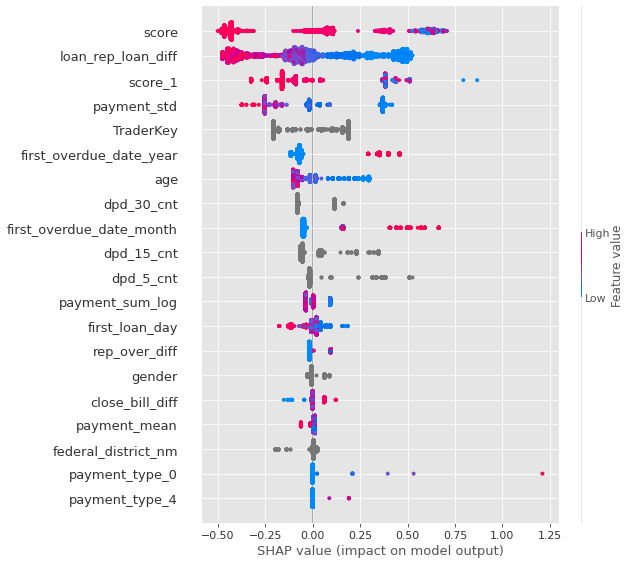

In [512]:
shap_values = cat_.get_feature_importance(train_pool_, type='ShapValues')

expected_value = shap_values[0,-1]
shap_values = shap_values[:,:-1]

shap.initjs()
shap.summary_plot(shap_values, X_train_)

So, nevertheless, the model is weak, here are some conclusions:
* high credit score gives lower probability of default
* like payment_type_3 also
* the older the customer the more responsible he is
* the bigger the time past from first loan before rep_loan the lower the probability of default is

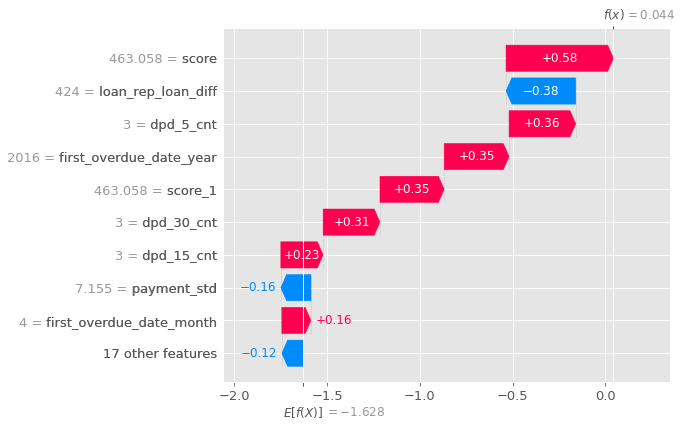

In [513]:
idx = 100
explainer = shap.TreeExplainer(cat_)
shap_values_one = explainer(X_test_.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

In [514]:
shap.force_plot(explainer.expected_value, shap_values[0], feature_names=X_train_.columns, features=X_test_.iloc[idx:idx+1],
                link='logit')
# baseline value is mean target in dataset

AUC_ROC = 0.816


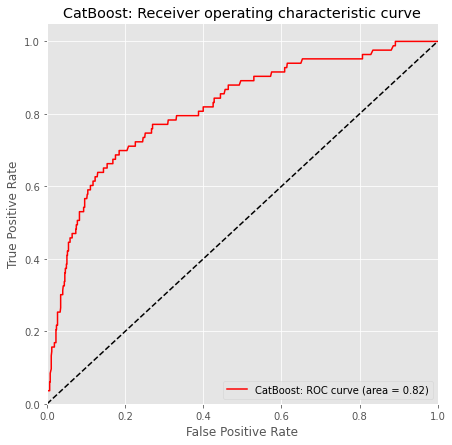

In [515]:
fpr, tpr, roc_thresholds = roc_curve(y_test_, test_probas)
precision, recall, pr_thresholds = precision_recall_curve(y_test_, test_probas)

plt.figure(figsize=(7, 7))
plot_roc_curve(fpr, tpr, "CatBoost", color='r')
print("AUC_ROC = %.3f" % auc(fpr, tpr))
# better than randam guessing

AUC_PR = 0.385


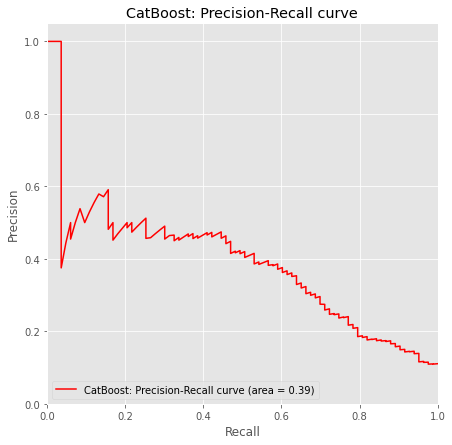

In [516]:
plt.figure(figsize=(7, 7))
    
plot_precision_recall_curve(recall, precision, "CatBoost", color='r')
print("AUC_PR = %.3f" % auc(recall, precision))
# poor result

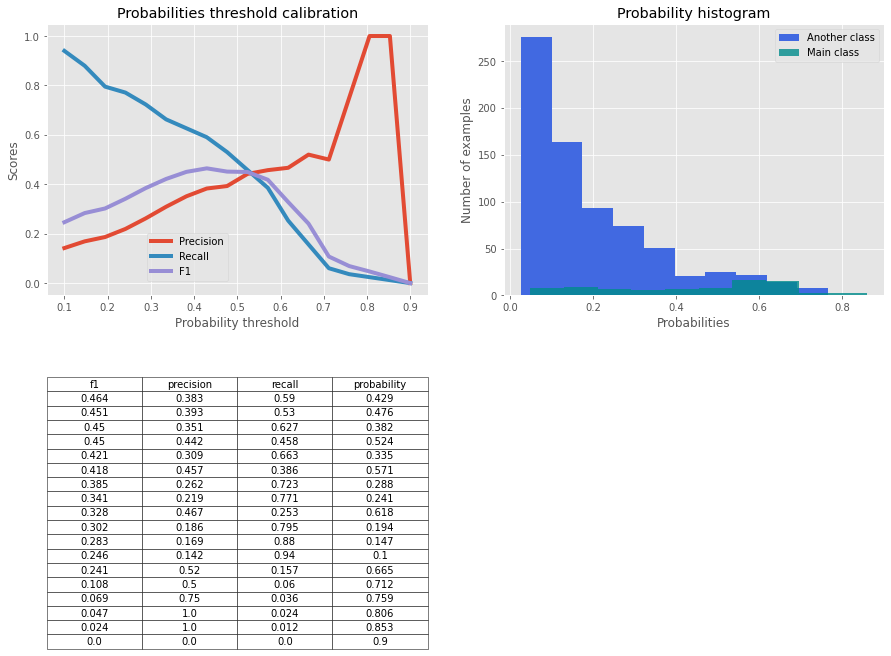

In [517]:
show_proba_calibration_plots(test_probas, y_test_)

Confusion matrix, without normalization


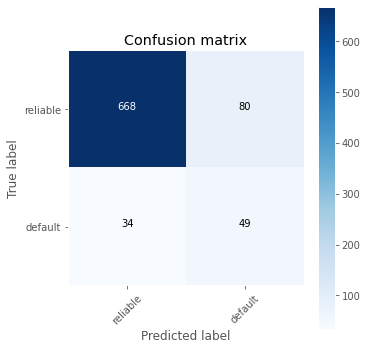

In [518]:
cnf_matrix = confusion_matrix(y_test_, test_probas>=0.429)
plt.figure(figsize=(5, 5))
plot_confusion_matrix(cnf_matrix, classes=['reliable', 'default'], normalize=False, title='Confusion matrix',)
plt.show()

As an improvement good practice is to define end-to-end pipeline with 'sklearn', 'luigi' or something else to make transforms, fit and final prediction tasks in one click

#### How to apply parallel boosting?
* select best threshold on different workers;
* Store full dataset on every worker;
* use subsamples of data, search local hists, than merge global hists where get best split.

#### Bagging, Voting (mean, gmean, rank), Stacking

1. Bagging: use different model parameters and/or different bootstraps (e.g. K-Folds) to train N models. The final answer is average of such predictions. Mean, Gmean, $(\prod_i^N{y_i})^{1/N}$, ranks, etc.;
2. Mean, Gmean, Rank (gmean(scores.rank(), axis=1)) to class probabilities like weighted majority voting obtained from different models, where weights can be chosen by hands or with e.g. scipy.optimize.minimize optimization function. Note, that model predictions must have Pearson correlation $\leq$ 97;
3. Stacking: use different nature models (or, at least, with different parameters) to make matrix of out-of-fold predictons (correlation $\leq$ 97) which are used to train (X={oof_preds1, ... oof_predsN}, y=true_labels) final model (LogisticRegression is a good starting point) to estimate final predictons (on test dataset).

In [658]:
def vote(predictions: list, weights: list = None, agg_type="vote", threshold=0.429):
    predictions = np.asarray(predictions).T
    if weights is None:
        weights = np.ones(shape=(predictions.shape[1],))
    if agg_type == "vote":
        predictions = (predictions >= threshold).astype(int)
        maj_vote = np.apply_along_axis(lambda x: np.argmax(np.bincount(x, weights=weights)), axis=1, arr=predictions)
        return maj_vote
    elif agg_type == "mean":
        return (predictions.mean(axis=1) >= threshold).astype(int)
    elif agg_type == "gmean":
         return (stats.gmean(predictions, axis=1) >= threshold).astype(int)
    elif agg_type == "rank":  # for probabilities
        predictions = pd.DataFrame(data=predictions)
        return (predictions.rank().mean(axis=1) >= threshold).astype(int)
    elif agg_type == "combine":  # for probabilities
        predictions = pd.DataFrame(data=predictions)
        return (stats.gmean(predictions.rank(), axis=1) >= threshold).astype(int)

In [642]:
# Bagging
model = CatBoostClassifier(cat_features=cat_features, **total_params)

estimators, _, _, fold_valid_scores, oof_preds = make_modify_cross_validation(X=X_train.drop(eliminated_features, axis=1), 
                                                                              y=y_train, 
                                                                              estimator=model, 
                                                                              metric=f1_score, 
                                                    cv_strategy=StratifiedKFold(n_splits=10, shuffle=True, random_state=seed),
                                                    error_to_be_outlier=False,
                                                    verbose=False)

scores = [estimator.predict_proba(X_test.drop(eliminated_features, axis=1))[:,1] for estimator in estimators]  # better valid
predictions = [estimator.predict_proba(X_test.drop(eliminated_features, axis=1))[:,1] for estimator in estimators]

CV-results train: 0.3963 +/- 0.021
CV-results valid: 0.3907 +/- 0.07
OOF-score = 0.3893


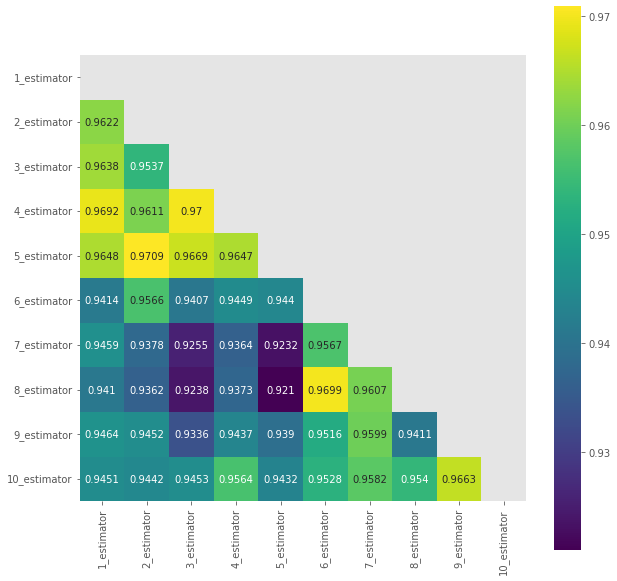

In [643]:
scores = pd.DataFrame({
    f"{i}_estimator": preds for i, preds in enumerate(predictions, 1)
})

corr = scores.corr()
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

fig, axes = plt.subplots(1, 1, figsize=(10, 10))
sns.heatmap(corr, mask=mask, annot=True, fmt=".4g", square=True, cmap="viridis", ax=axes)
plt.show()
# models correlation (<=0.97) is acceptable

In [659]:
print(f"F1 score by weighted majority vote: {f1_score(y_test, vote(predictions)):2.4f}")
print(f"F1 score mean:                      {f1_score(y_test, vote(predictions, agg_type='mean')):2.4f}")
print(f"F1 score geometric mean:            {f1_score(y_test, vote(predictions, agg_type='gmean')):2.4f}")
print(f"F1 score rank:                      {f1_score(y_test, vote(predictions, agg_type='rank')):2.4f}")
print(f"F1 score combine:                   {f1_score(y_test, vote(predictions, agg_type='combine')):2.4f}")

F1 score by weighted majority vote: 0.3582
F1 score mean:                      0.3529
F1 score geometric mean:            0.3547
F1 score rank:                      0.1814
F1 score combine:                   0.1814


In [683]:
from scipy.optimize import minimize

results_list = []   
weights_list = []  
preds = np.array(predictions).T

def weights_objective(weights):
    y_ens = np.average(preds, axis=1, weights=weights)
    return f1_score(y_test, y_ens >= 0.429)  # use y_train here in production

for k in range(1000):
  
    w0 = np.random.uniform(size=preds.shape[1])
    bounds = [(0,1)] * preds.shape[1]

    cons = [{'type': 'eq',
             'fun': lambda w: w.sum() - 1}]

    res = minimize(weights_objective,
                   w0,
                   method='SLSQP',
                   bounds=bounds,
                   options={'disp':False, 'maxiter':10000},
                   constraints=cons)

    results_list.append(res.fun)
    weights_list.append(res.x)

best_score = np.max(results_list)    
best_weights = weights_list[results_list.index(best_score)]

print('\nOptimized weights:')
print('Best score: {:.4f}'.format(best_score))


Optimized weights:
Best score: 0.3707


In [684]:
print(f"F1 score by weighted majority vote: {f1_score(y_test, vote(predictions, weights=list(best_weights))):2.4f}")
# optimizing did not help a lot

F1 score by weighted majority vote: 0.3575


#### Stacking

In [695]:
from sklearn.ensemble import StackingClassifier

model = CatBoostClassifier(cat_features=cat_features, **total_params)

stack = StackingClassifier(estimators=[(f'model_{i}', model.copy()) for i in range(1, 11)],  # catboost models
                           cv=10, # validate on 5 folds
                           stack_method='predict_proba',  # use probabilities as factors 
                           n_jobs=-1,  # use all cpus
                           passthrough=False,  # use only probabilities to train, otherwise use model features as well
                           final_estimator=LogisticRegression(random_state=seed, n_jobs=-1, C=0.1)
                          ).fit(X_train.drop(eliminated_features, axis=1), y_train)  

In [696]:
probs = stack.predict_proba(X_test.drop(eliminated_features, axis=1))[:,1]

get_best_threshold(y_test, probs)

(0.1609145028412318, 0.3842794759825327)

In [702]:
scores = create_bootstrap_metrics(y_train, stack.predict_proba(X_train.drop(eliminated_features, axis=1))[:,1]>=0.1609145028412318, f1_score)

calculate_confidence_interval(scores)  
# the proper way is to construct CI on validation split and check test metric to lie into it (here it is more to visualize)

(0.37400666943012884, 0.4563341312447418)

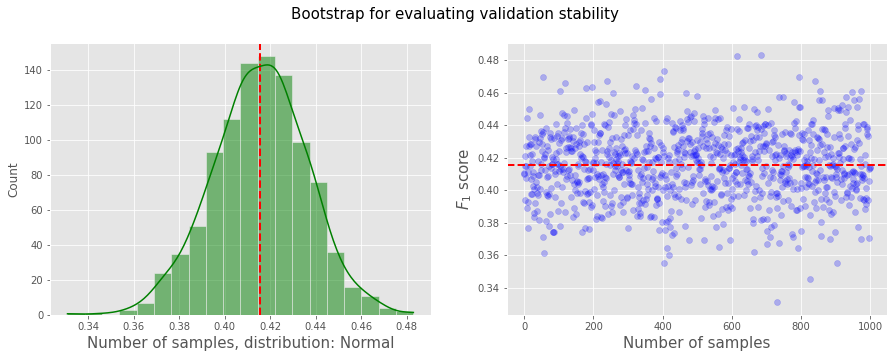

In [703]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plt.suptitle("Bootstrap for evaluating validation stability", size=15)
axes[1].scatter(range(len(scores)), scores, alpha=0.25, color="blue")
axes[1].set_xlabel("Number of samples", size=15)
axes[1].set_ylabel("$F_1$ score", size=15)
distribution = "Normal" if stats.shapiro(scores)[1] >= 0.05 else "Not normal"

axes[0].axvline(np.mean(scores), lw=2, ls='--', c='red')
axes[1].axhline(np.mean(scores), lw=2, ls='--', c='red')
sns.histplot(scores, ax=axes[0], color="green", bins=20, kde=True)
axes[0].set_xlabel(f"Number of samples, distribution: {distribution}", size=15)
plt.show()
# scatter plot is very sparsed, test distribution looks like close to gaussian
# cv is built correctly if metric, calculated with ground truth labels lies in CI